## GPT-4 inference
https://github.com/openai/openai-cookbook/blob/main/

### pricing  
(https://openai.com/pricing)  
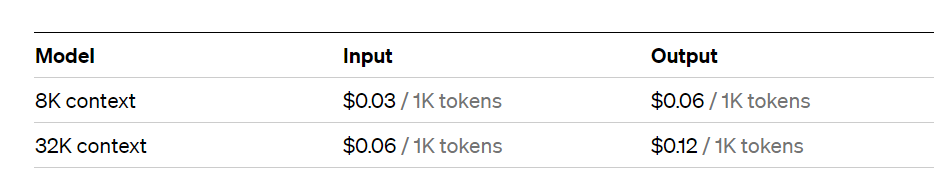  
gpt-4 price  
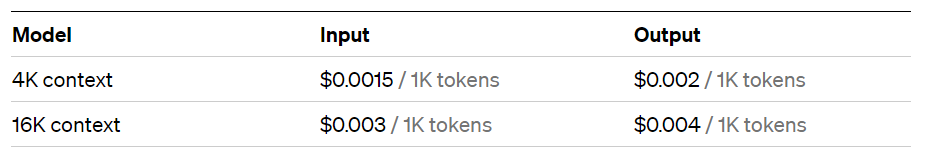  
gpt-3.5 turbo

새롭게 정책이 변경되어서 매달 후불 요금제에서 신규 유저는 선불요금제로 변경되었다.(https://help.openai.com/en/articles/8264644-what-is-prepaid-billing)  
최소 5$에서 최대 50$까지 충전하여 사용가능하다. 충전된 credit이 부족하면 error가 발생하니 주의해야 된다.  

In [2]:
import openai
openai.api_key = '' # put it your personal key (https://platform.openai.com/account/api-keys)

### tokenizer
gpt의 tokenizer는 3종류가 있다. 사용할 모델에 맞춰 선택하면 된다.

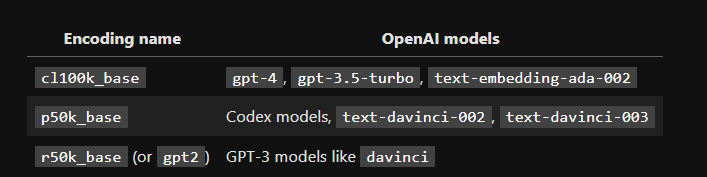

In [3]:
# load chat-gpt tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
len(tokenizer.encode('You are a smart classifier.'))

6

Tiktoken은 BPE(byte pair encoding)기반으로 빠르게 최적화된 openai의 tokenizer이다.

In [13]:
# https://github.com/openai/tiktoken/blob/main/tiktoken/core.py
print(tokenizer._special_tokens)
print(tokenizer.n_vocab)
print(tokenizer.max_token_value)
print(tokenizer)

{'<|endoftext|>': 100257, '<|fim_prefix|>': 100258, '<|fim_middle|>': 100259, '<|fim_suffix|>': 100260, '<|endofprompt|>': 100276}
100277
100276
<Encoding 'cl100k_base'>


In [3]:
# calculate the number of tokens in sentence 
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
    """Return the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif "gpt-3.5-turbo" in model:
        print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
    elif "gpt-4" in model:
        print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens


In [ ]:
# 3(token 당 3개) + 6('content'의 토큰수) + 1(token 이름당 1개) + special token(+3)
num_tokens_from_messages([{'role' : 'system' , 'content':'You are a smart classifier.'}]) 

In [ ]:
# princing 4K context = input : $0.0015 / 1K tokens	
#                       output : $0.002 / 1K tokens
#          16K context = input : $0.003 / 1K tokens	
#                       output : $0.004 / 1K tokens

### Chat completion
chat completion이란 api를 사용하여 gpt의 result를 얻을 수 있다. completion을 하기 위해선 model과 messages가 필요하다.  
1. model은 원하는 모델을 선택하면 된다.(e.g., gpt-3.5-turbo, gpt-4, gpt-3.5-turbo-0613, gpt-3.5-turbo-16k-0613)  
2. messages는 role(system, user, or assistant)와 content로 이루어져 있다.  

In [6]:
messages = [{'role' : 'system' , 'content':'You are a smart classifier.'}] # gpt에게 역할을 설정할 수 있다.
messages.append({'role':'user', 'content': 'Tell how to make LLM'})
if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
    res = openai.ChatCompletion.create(model = 'gpt-3.5-turbo-16k-0613', messages = messages, max_tokens = 25)
else:
    res = openai.ChatCompletion.create(model = 'gpt-3.5-turbo-0613', messages = messages, max_tokens = 25)
res # json 형태의 data가 생성된다. 
# res['choices'][0]['message']['content'] 로 정답을 볼수 있다. 
# res['usage']['total_tokens'] 으로 생성한 token수를 측정할 수 있다.

<OpenAIObject chat.completion id=chatcmpl-7qknm3vb0q35T30z7jJYDV187dm5W at 0x1e92ad24e90> JSON: {
  "id": "chatcmpl-7qknm3vb0q35T30z7jJYDV187dm5W",
  "object": "chat.completion",
  "created": 1692807318,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "LLM, or Language Model, is a type of machine learning model trained on a large dataset of text to generate human-like"
      },
      "finish_reason": "length"
    }
  ],
  "usage": {
    "prompt_tokens": 23,
    "completion_tokens": 25,
    "total_tokens": 48
  }
}

In [7]:
print(res['choices'][0]['message']['content'])
print(res['usage']['total_tokens'])

LLM, or Language Model, is a type of machine learning model trained on a large dataset of text to generate human-like
48


In [3]:
# system prompt 가 없는 예시
response = openai.ChatCompletion.create(
    model= 'gpt-3.5-turbo-0613',
    messages=[
        {"role": "user", "content": "Explain asynchronous programming in the style of the pirate Blackbeard."},
    ],
    temperature=0,
)

print(response)

{
  "id": "chatcmpl-7sXgxJjoAtcBKB0AkfLE9KWgLGQCd",
  "object": "chat.completion",
  "created": 1693233579,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Arr, me hearties! Gather 'round and listen up, for I be tellin' ye about the mysterious art of asynchronous programming, in the style of the fearsome pirate Blackbeard!\n\nNow, ye see, in the world of programming, there be times when we need to perform tasks that take a mighty long time to complete. These tasks might involve fetchin' data from the depths of the internet or performin' complex calculations that would make even Davy Jones scratch his head.\n\nIn the olden days, we used to wait patiently for these tasks to finish afore movin' on to the next one. But, me mateys, that be a waste of precious time! We pirates be always lookin' for ways to be more efficient, and that's where asynchronous programming comes into play.\n\nWith asynchrono

In [5]:
print("Arr, me hearties! Gather 'round and listen up, for I be tellin' ye about the mysterious art of asynchronous programming, in the style of the fearsome pirate Blackbeard!\n\nNow, ye see, in the world of programming, there be times when we need to perform tasks that take a mighty long time to complete. These tasks might involve fetchin' data from the depths of the internet or performin' complex calculations that would make even Davy Jones scratch his head.\n\nIn the olden days, we used to wait patiently for these tasks to finish afore movin' on to the next one. But, me mateys, that be a waste of precious time! We pirates be always lookin' for ways to be more efficient, and that's where asynchronous programming comes into play.\n\nWith asynchronous programming, we can set sail on multiple tasks at once, without waitin' for one to finish afore startin' another. It be like havin' a crew of scallywags workin' on different tasks simultaneously, each one reportin' back when they be done.\n\nYe see, in this style of programmin', we make use of somethin' called \"callbacks\" or \"promises.\" These be like messages in a bottle that we send to our crewmates, tellin' 'em what to do and where to report back.\n\nWhen we send a task to be done asynchronously, we don't wait around for it to finish. Instead, we move on to the next task, keepin' our ship sailin' smoothly. Meanwhile, the task be workin' away in the background, like a stealthy pirate scout gatherin' information.\n\nOnce the task be finished, it sends a message back to us, lettin' us know it's done. We can then handle the results of the task and continue our journey through the treacherous seas of code.\n\nThis be a powerful way of programmin', me hearties, as it allows us to make the most of our time and keep our ship runnin' at full speed. We can tackle multiple tasks at once, without gettin' bogged down by waitin' for each one to finish.\n\nBut, ye must be careful, me mateys! Asynchronous programmin' can be a bit tricky to master. Ye need to ensure that ye handle the messages from yer crewmates properly, or ye might end up with a ship full of errors and bugs.\n\nSo, me hearties, that be the tale of asynchronous programmin' in the style of the pirate Blackbeard! It be a powerful tool in the hands of a skilled programmer, allowin' us to conquer the vast seas of code with speed and efficiency. Now, set sail and may the winds of asynchronous programmin' be at yer back!")

Arr, me hearties! Gather 'round and listen up, for I be tellin' ye about the mysterious art of asynchronous programming, in the style of the fearsome pirate Blackbeard!

Now, ye see, in the world of programming, there be times when we need to perform tasks that take a mighty long time to complete. These tasks might involve fetchin' data from the depths of the internet or performin' complex calculations that would make even Davy Jones scratch his head.

In the olden days, we used to wait patiently for these tasks to finish afore movin' on to the next one. But, me mateys, that be a waste of precious time! We pirates be always lookin' for ways to be more efficient, and that's where asynchronous programming comes into play.

With asynchronous programming, we can set sail on multiple tasks at once, without waitin' for one to finish afore startin' another. It be like havin' a crew of scallywags workin' on different tasks simultaneously, each one reportin' back when they be done.

Ye see, in 

In [4]:
# fewshot 예제이다. user와 assistant가 번갈아가며 응답을 받는다.
response = openai.ChatCompletion.create(
    model= 'gpt-3.5-turbo-0613',
    messages=[
        {"role": "system", "content": "You are a helpful, pattern-following assistant."},
        {"role": "user", "content": "Help me translate the following corporate jargon into plain English."},
        {"role": "assistant", "content": "Sure, I'd be happy to!"},
        {"role": "user", "content": "New synergies will help drive top-line growth."},
        {"role": "assistant", "content": "Things working well together will increase revenue."},
        {"role": "user", "content": "Let's circle back when we have more bandwidth to touch base on opportunities for increased leverage."},
        {"role": "assistant", "content": "Let's talk later when we're less busy about how to do better."},
        {"role": "user", "content": "This late pivot means we don't have time to boil the ocean for the client deliverable."},
    ],
    temperature=0,
)

print(response["choices"][0]["message"]["content"])

This sudden change in direction means we don't have enough time to complete the entire project for the client.


In [ ]:
# stream=True 예시
# https://platform.openai.com/docs/guides/chat

# a ChatCompletion request
response = openai.ChatCompletion.create(
    model= 'gpt-3.5-turbo-0613',
    messages=[
        {'role': 'user', 'content': "What's 1+1? Answer in one word."}
    ],
    temperature=0,
    stream=True  # this time, we set stream=True
)

for chunk in response:
    print(chunk) # answer가 순차적으로 생성되는 stream 예제 시간은 미묘하게 확률적으로 다르다, 답변만 볼려면 chunk['choices']['delta']['content']

{
  "id": "chatcmpl-7qmTyALcYHZKMk5SgR64R0aQmYAKW",
  "object": "chat.completion.chunk",
  "created": 1692813778,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "delta": {
        "role": "assistant",
        "content": ""
      },
      "finish_reason": null
    }
  ]
}
{
  "id": "chatcmpl-7qmTyALcYHZKMk5SgR64R0aQmYAKW",
  "object": "chat.completion.chunk",
  "created": 1692813778,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "delta": {
        "content": "2"
      },
      "finish_reason": null
    }
  ]
}
{
  "id": "chatcmpl-7qmTyALcYHZKMk5SgR64R0aQmYAKW",
  "object": "chat.completion.chunk",
  "created": 1692813778,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "delta": {},
      "finish_reason": "stop"
    }
  ]
}


### Rate limit
(현재 우리 Tips 과제의 inference에는 해당되지 않는 부분이다.)  
api를 무작정 사용하다 보면 limit을 맞이 할수 있다. openai에서는 남용및 잘못된 사용을 막고 효육적으로 시스템을 구축하기 위해 일부러 설정해놓은 시스템이다.  
아래 그림은 2023년 1월 기준으로 설정된 limit이다.  
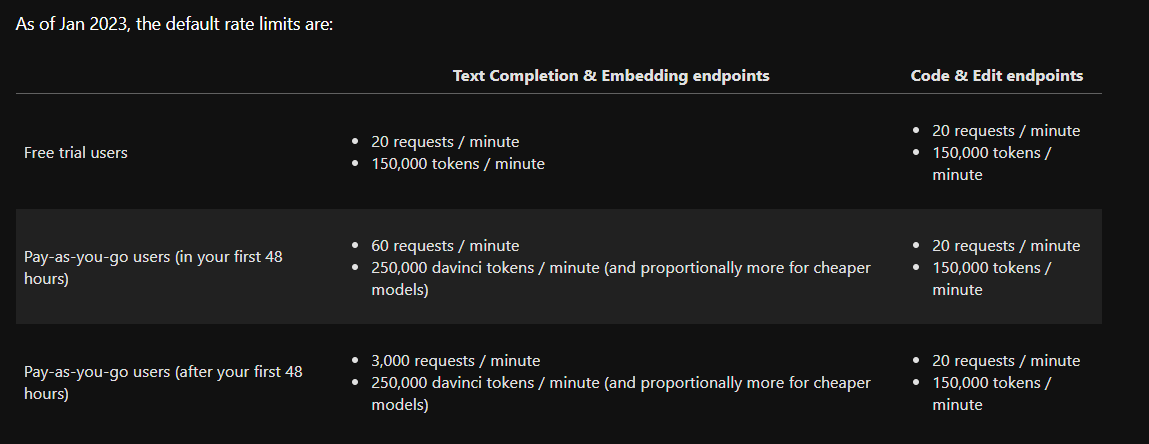 

한장에 1000토큰 정도 된다고 한다.  
따로 요청해서 (https://docs.google.com/forms/d/e/1FAIpQLSc6gSL3zfHFlL6gNIyUcjkEv29jModHGxg5_XGyr-PrE2LaHw/viewform) 제한량을 늘릴수도 있는것 같다.  
20번 이상하면 이런 에러가 발생한다고 한다.   
    RateLimitError: Rate limit reached for default-codex in organization org-{id} on requests per min. Limit: 20.000000 / min. Current: 24.000000 / min. Contact support@openai.com if you continue to have issues or if you’d like to request an increase.

In [6]:
#error가 발생 안할 수도 있다.
for _ in range(100):
    openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": "Hello"}],
        max_tokens=10,
    )

Exponential backoff with jitter 설명(https://velog.io/@jazz_avenue/%EC%A2%80-%EB%8D%94-%EC%9A%B0%EC%95%84%ED%95%9C-Retry-Expenential-Backoff-with-Jitter)  
Exponential Backoff 전략에서는 지수에 비례하여 Backoff 시간을 조절하는데 다음과 같은 방식으로 동작한다.  
첫번째 시도를 위한 대기 시간을 100ms, 두번째 재시도를 위한 대기 시간을 200ms, 세번째 재시도를 위한 대기시간을 400ms ...(점차 지수적으로 증가한다)  
추가적으로 Jitter(패킷의 지연이 수시로 변하면서 그 간격이 일정하지 않는 현상 즉, 지연 변이를 의미)를 사용하여 약간의 무작위성을 더할 수 있다.(동시성을 피하기 위해)  

exponential backoff(컴퓨터 네트워크 통신에서 사용되는 재시도 전략 중 하나)를 하기 위해 Tenacity library(https://tenacity.readthedocs.io/en/latest/)가 존재한다.  

In [8]:
!pip install tenacity

In [ ]:
import openai  # for OpenAI API calls
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

# 6번 시도후 멈춤 + 1부터 60까지 랜덤하게 지수적으로 기다림
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.Completion.create(**kwargs)

completion_with_backoff(model="text-davinci-002", prompt="Once upon a time,")

In [ ]:
import backoff  # for exponential backoff 위와 유사한 library가 존재한다. (https://pypi.org/project/backoff/)
import openai  # for OpenAI API calls

# openai.error.RateLimitError 이 에러가 발생했을때 지수적으로 총 6번까지 재시도한다.
@backoff.on_exception(backoff.expo, openai.error.RateLimitError, max_tries = 6)
def completions_with_backoff(**kwargs):
    return openai.Completion.create(**kwargs)

completions_with_backoff(model="text-davinci-002", prompt="Once upon a time,")

time.sleep(delay_in_seconds)을 사용하여도 좋고 batch 단위로(그냥 하는거랑 유사함) 사용하는 방법도 존재한다.  
마지막으로 parallel processing을 하는 방법이 있는데 예제 파일을 참조하면 된다.  
(https://github.com/openai/openai-cookbook/blob/35b7123fafd3cb10bb5e30ea01bc78d6d9ee5fb0/examples/api_request_parallel_processor.py)  
1. Streams requests from file, to avoid running out of memory for giant jobs # 요청을 스트리밍
2. Makes requests concurrently, to maximize throughput # 요청을 동시에 수행
3. Throttles both request and token usage, to stay under rate limits # 요청과 토큰 사용량을 모두 조절하여 속도 제한을 유지
4. Retries failed requests, to avoid missing data # 실패한 요청을 다시 시도하여 데이터 누락을 방지
5. Logs errors, to diagnose problems with requests  # 오류를 기록하여 요청의 문제를 진단  


### Text Embedding model for text classification  
(https://openai.com/blog/introducing-text-and-code-embeddings)  

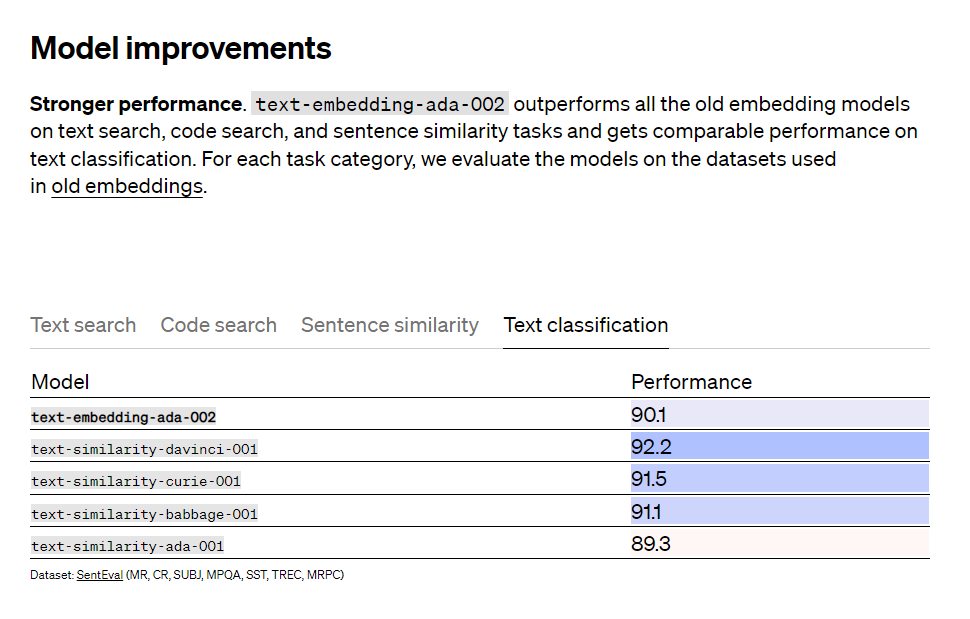  
SentEval: evaluation toolkit for sentence embeddings(17 downstream tasks, 10 probing tasks)

아래 그림은 위에서 주장하는 old embeddings의 성능지표이다.

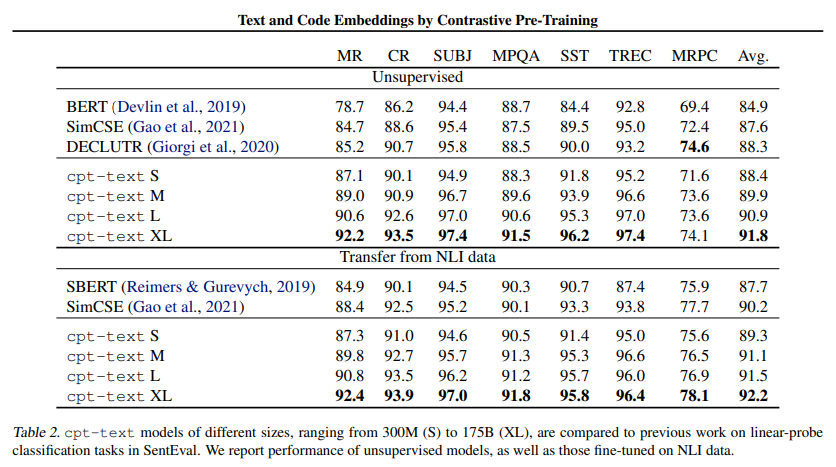  
위에서 주장하는 outperform이 차이가 미미한거 같음. (+그래서 가격이 저렴한것 같음)  
0.0004$ per 1000 tokens, or 1$ per bout 3,000 pages  US dollar (assuming ~800 tokens per page)

이제 1. api를 사용하여 '질문' column의 embedding을 구하고 2. RandomForestClassifier 나 Support Vector Machine을 사용하여 classify 해보자

In [47]:
# (https://github.com/openai/openai-cookbook/blob/35b7123fafd3cb10bb5e30ea01bc78d6d9ee5fb0/examples/Obtain_dataset.ipynb)
import pandas as pd
import numpy as np
import tiktoken

from ast import literal_eval # string을 python code로 읽어줌 ex) literal_eval('1+1') = 1+1
from openai.embeddings_utils import get_embedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [68]:
train_data_path = "./data/solvook_handout_tr.csv"   # put your data path
test_data_path = "./data/solvook_handout_te.csv"    # put your data path
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
train_df.head(1)

,Unnamed: 0,본문,조건,선지,정답,질문,문제유형,skill,method
0,7895,The true champion recognizes that excellence o...,NaN,· 답(1) : _____ · 수정 후 : _______________ \n· 답(...,④ was ⑤ that,"다음 글의 밑줄 친 부분 중, 어법상 틀린 것을 두 개 골라 올바르게 고치시오.",20.0,4,4


In [2]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [69]:
encoding = tiktoken.get_encoding(embedding_encoding)
train_df["n_tokens"] = train_df.질문.apply(lambda x: len(encoding.encode(x))) # cal num of tokens
test_df["n_tokens"] = test_df.질문.apply(lambda x: len(encoding.encode(x))) 
train_df = train_df[train_df.n_tokens <= max_tokens]
test_df = test_df[test_df.n_tokens <= max_tokens] # 8000 넘으면 지우는데 사실 넘을 일 없음
train_df.head(1)

,Unnamed: 0,본문,조건,선지,정답,질문,문제유형,skill,method,n_tokens
0,7895,The true champion recognizes that excellence o...,NaN,· 답(1) : _____ · 수정 후 : _______________ \n· 답(...,④ was ⑤ that,"다음 글의 밑줄 친 부분 중, 어법상 틀린 것을 두 개 골라 올바르게 고치시오.",20.0,4,4,46


In [ ]:
# This may take a few minutes (about 50 min)
train_df["embedding"] = train_df.질문.apply(lambda x: get_embedding(x, engine=embedding_model))
test_df["embedding"] = test_df.질문.apply(lambda x: get_embedding(x, engine=embedding_model))
train_df.to_csv("./data/Tips_query_embedding_tr.csv")
test_df.to_csv("./data/Tips_query_embedding_te.csv")
print(len(train_df), len(test_df)) # embedding 차원은 1536

In [280]:
# (https://github.com/openai/openai-cookbook/blob/main/examples/Classification_using_embeddings.ipynb)
# load data
train_embedding_path = "./data/Tips_query_embedding_tr.csv"
test_embedding_path = "./data/Tips_query_embedding_te.csv"

train_df = pd.read_csv(train_embedding_path)
test_df = pd.read_csv(test_embedding_path)
train_df["embedding"] = train_df.embedding.apply(literal_eval).apply(np.array)  # convert string to array
test_df["embedding"] = test_df.embedding.apply(literal_eval).apply(np.array)
train_df.head(1)

,Unnamed: 0.1,Unnamed: 0,본문,조건,선지,정답,질문,문제유형,skill,method,n_tokens,embedding
0,0,7895,The true champion recognizes that excellence o...,NaN,· 답(1) : _____ · 수정 후 : _______________ \n· 답(...,④ was ⑤ that,"다음 글의 밑줄 친 부분 중, 어법상 틀린 것을 두 개 골라 올바르게 고치시오.",20.0,4,4,46,"[-0.00855891965329647, 0.00996965542435646, 0...."


In [278]:
# plot_heatmap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_heatmap(label, preds, label_name='Skill'):
    cm = confusion_matrix(label, preds)
    unique_list = np.unique(np.array([label, preds]))
    accuracy = sum([cm[i, i] for i in range(len(unique_list))]) / len(unique_list)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=unique_list, yticklabels=unique_list)
    plt.title(f"Accuracy: {accuracy:.2f}")
    plt.xlabel('Predict')
    plt.ylabel(label_name)
    plt.title(f'{label_name} Confusion Matrix')
    plt.show()
    
    print(classification_report(label, preds))

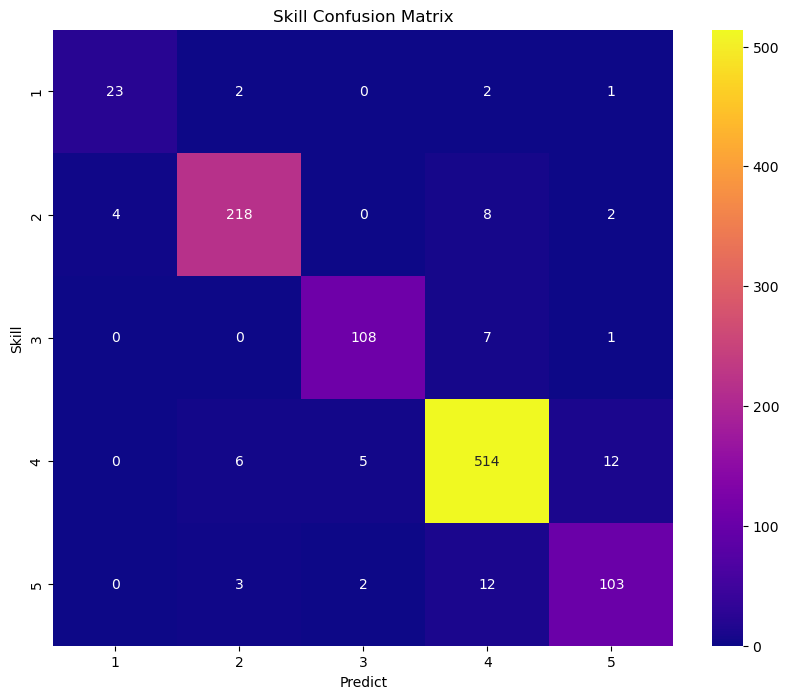

              precision    recall  f1-score   support

           1       0.85      0.82      0.84        28
           2       0.95      0.94      0.95       232
           3       0.94      0.93      0.94       116
           4       0.95      0.96      0.95       537
           5       0.87      0.86      0.86       120

    accuracy                           0.94      1033
   macro avg       0.91      0.90      0.91      1033
weighted avg       0.93      0.94      0.94      1033



In [281]:
# Applying random forest classifier to skill
X_train, X_test = train_df.embedding.values.tolist(), test_df.embedding.values.tolist()
y_train, y_test =  train_df.skill.values.astype(int), test_df.skill.values.astype(int)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
plot_heatmap(y_test, preds, 'Skill')

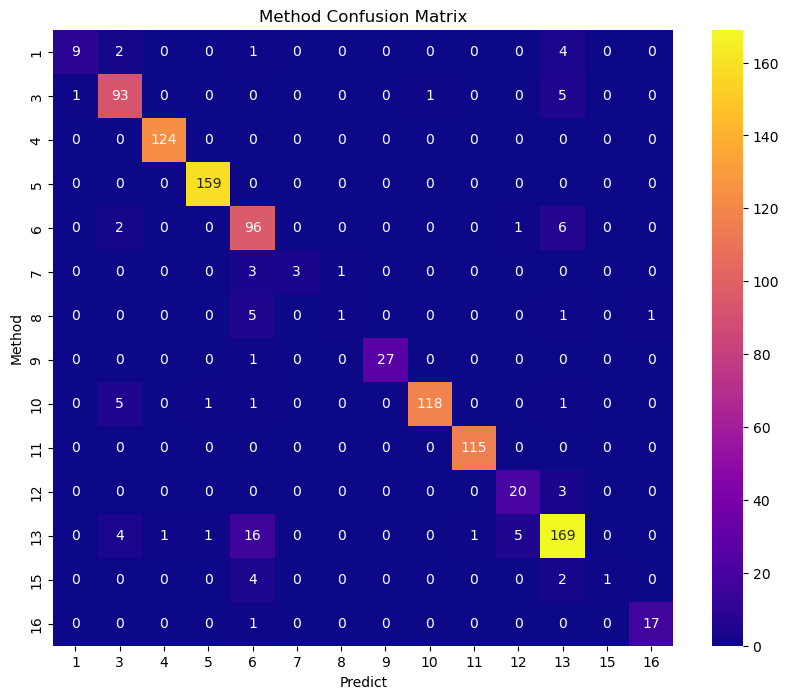

              precision    recall  f1-score   support

           1       0.90      0.56      0.69        16
           3       0.88      0.93      0.90       100
           4       0.99      1.00      1.00       124
           5       0.99      1.00      0.99       159
           6       0.75      0.91      0.82       105
           7       1.00      0.43      0.60         7
           8       0.50      0.12      0.20         8
           9       1.00      0.96      0.98        28
          10       0.99      0.94      0.96       126
          11       0.99      1.00      1.00       115
          12       0.77      0.87      0.82        23
          13       0.88      0.86      0.87       197
          15       1.00      0.14      0.25         7
          16       0.94      0.94      0.94        18

    accuracy                           0.92      1033
   macro avg       0.90      0.76      0.79      1033
weighted avg       0.92      0.92      0.92      1033

              precision  

In [282]:
# Applying random forest classifier to method
X_train, X_test = train_df.embedding.values.tolist(), test_df.embedding.values.tolist()
y_train, y_test =  train_df.method.values.astype(int), test_df.method.values.astype(int)
clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
plot_heatmap(y_test, preds, 'Method')
print(report)

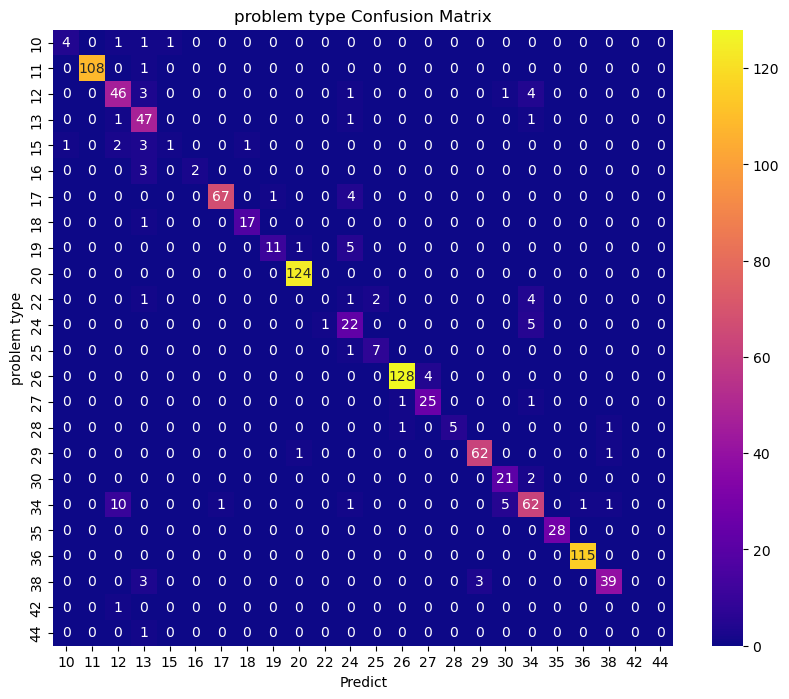

              precision    recall  f1-score   support

          10       0.80      0.57      0.67         7
          11       1.00      0.99      1.00       109
          12       0.75      0.84      0.79        55
          13       0.73      0.94      0.82        50
          15       0.50      0.12      0.20         8
          16       1.00      0.40      0.57         5
          17       0.99      0.93      0.96        72
          18       0.94      0.94      0.94        18
          19       0.92      0.65      0.76        17
          20       0.98      1.00      0.99       124
          22       0.00      0.00      0.00         8
          24       0.61      0.79      0.69        28
          25       0.78      0.88      0.82         8
          26       0.98      0.97      0.98       132
          27       0.86      0.93      0.89        27
          28       1.00      0.71      0.83         7
          29       0.95      0.97      0.96        64
          30       0.78    

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [283]:
# Applying random forest classifier to problem type
X_train, X_test = train_df.embedding.values.tolist(), test_df.embedding.values.tolist()
y_train, y_test =  train_df.문제유형.values.astype(int), test_df.문제유형.values.astype(int)
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
plot_heatmap(y_test, preds, 'problem type')
print(report)

In [ ]:
# support vector machine
from sklearn import svm
from ast import literal_eval

train_embedding_path = "./data/Tips_query_embedding_tr.csv"
test_embedding_path = "./data/Tips_query_embedding_te.csv"

train_df = pd.read_csv(train_embedding_path)
test_df = pd.read_csv(test_embedding_path)
train_df["embedding"] = train_df.embedding.apply(literal_eval).apply(np.array)  # convert string to array
test_df["embedding"] = test_df.embedding.apply(literal_eval).apply(np.array)

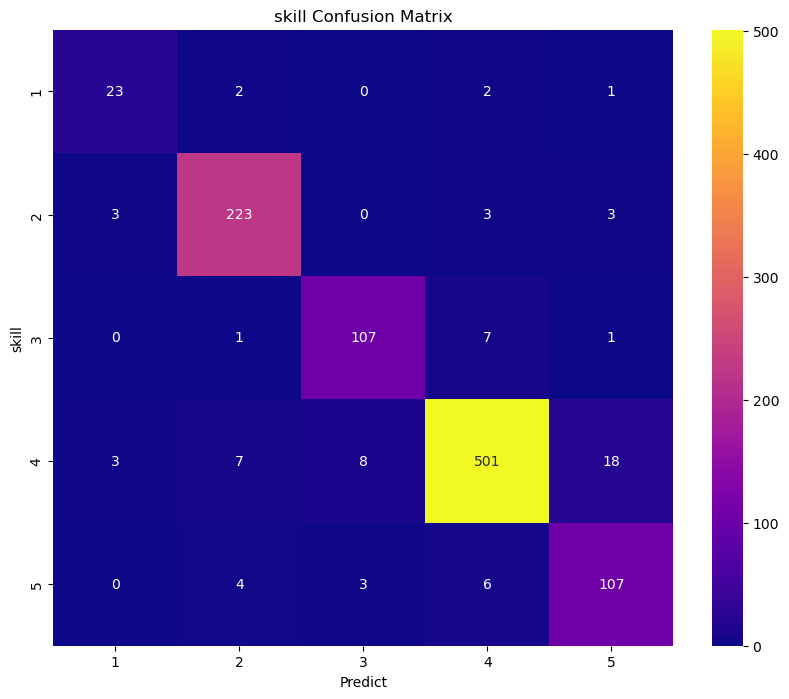

              precision    recall  f1-score   support

           1       0.79      0.82      0.81        28
           2       0.94      0.96      0.95       232
           3       0.91      0.92      0.91       116
           4       0.97      0.93      0.95       537
           5       0.82      0.89      0.86       120

    accuracy                           0.93      1033
   macro avg       0.89      0.91      0.90      1033
weighted avg       0.93      0.93      0.93      1033



In [284]:
# Applying support vector machine to skill
X_train, X_test = train_df.embedding.values.tolist(), test_df.embedding.values.tolist()
y_train, y_test = train_df.skill.values.astype(int), test_df.skill.values.astype(int)

clf = svm.SVC(C = 10.0, kernel='rbf', gamma=0.1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
plot_heatmap(y_test, preds, 'skill')

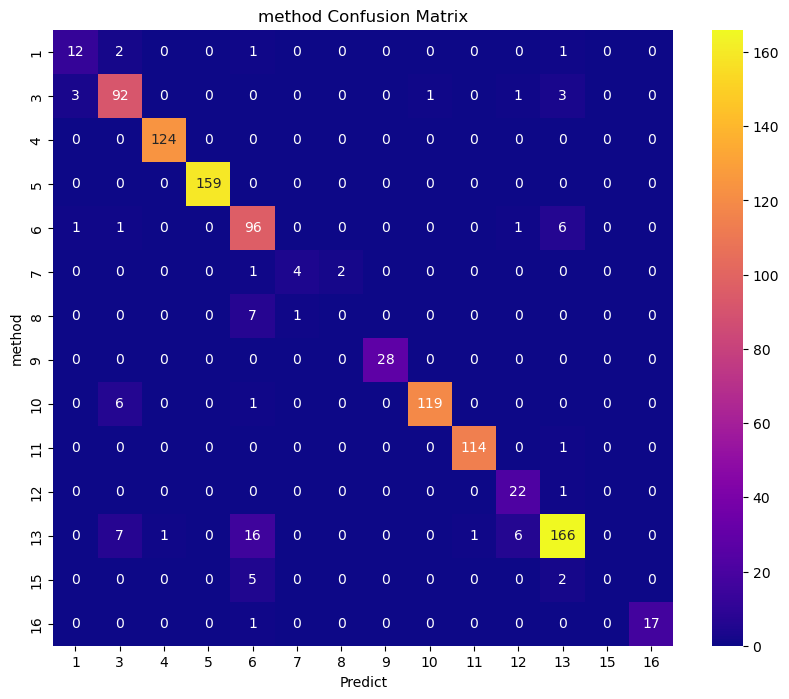

              precision    recall  f1-score   support

           1       0.75      0.75      0.75        16
           3       0.85      0.92      0.88       100
           4       0.99      1.00      1.00       124
           5       1.00      1.00      1.00       159
           6       0.75      0.91      0.82       105
           7       0.80      0.57      0.67         7
           8       0.00      0.00      0.00         8
           9       1.00      1.00      1.00        28
          10       0.99      0.94      0.97       126
          11       0.99      0.99      0.99       115
          12       0.73      0.96      0.83        23
          13       0.92      0.84      0.88       197
          15       0.00      0.00      0.00         7
          16       1.00      0.94      0.97        18

    accuracy                           0.92      1033
   macro avg       0.77      0.77      0.77      1033
weighted avg       0.92      0.92      0.92      1033



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [286]:
# Applying support vector machine to method
X_train, X_test = train_df.embedding.values.tolist(), test_df.embedding.values.tolist()
y_train, y_test = train_df.method.values.astype(int), test_df.method.values.astype(int)

clf = svm.SVC(C = 10.0, kernel='rbf', gamma=0.1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
plot_heatmap(y_test, preds, 'method')

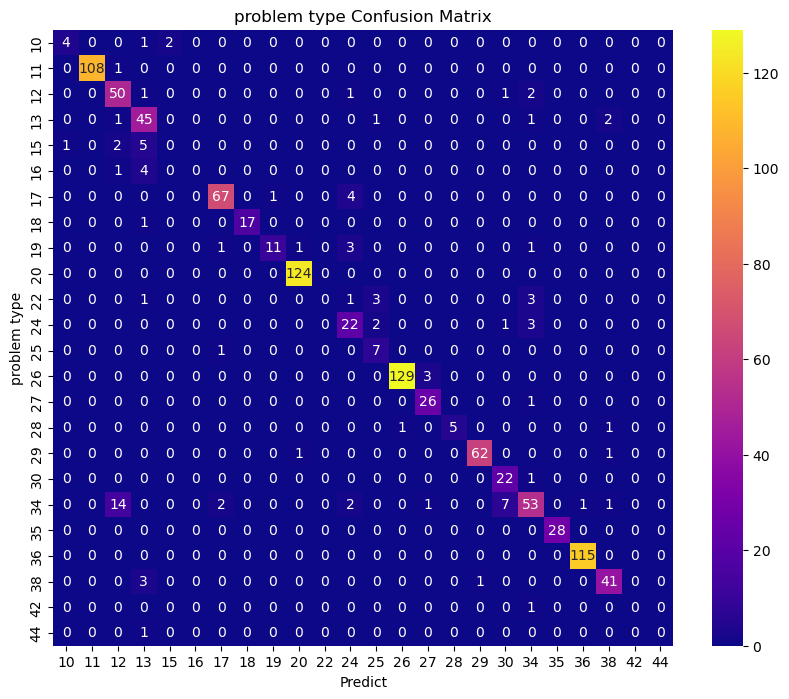

              precision    recall  f1-score   support

          10       0.80      0.57      0.67         7
          11       1.00      0.99      1.00       109
          12       0.72      0.91      0.81        55
          13       0.73      0.90      0.80        50
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         5
          17       0.94      0.93      0.94        72
          18       1.00      0.94      0.97        18
          19       0.92      0.65      0.76        17
          20       0.98      1.00      0.99       124
          22       0.00      0.00      0.00         8
          24       0.67      0.79      0.72        28
          25       0.54      0.88      0.67         8
          26       0.99      0.98      0.98       132
          27       0.87      0.96      0.91        27
          28       1.00      0.71      0.83         7
          29       0.98      0.97      0.98        64
          30       0.71    

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [287]:
# Applying support vector machine to problem type
X_train, X_test = train_df.embedding.values.tolist(), test_df.embedding.values.tolist()
y_train, y_test =  train_df.문제유형.values.astype(int), test_df.문제유형.values.astype(int)

clf = svm.SVC(C = 10.0, kernel='rbf', gamma=0.1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
plot_heatmap(y_test, preds, 'problem type')

Text(0.5, 1.0, 'query embedding t-SNE (color by skill)')

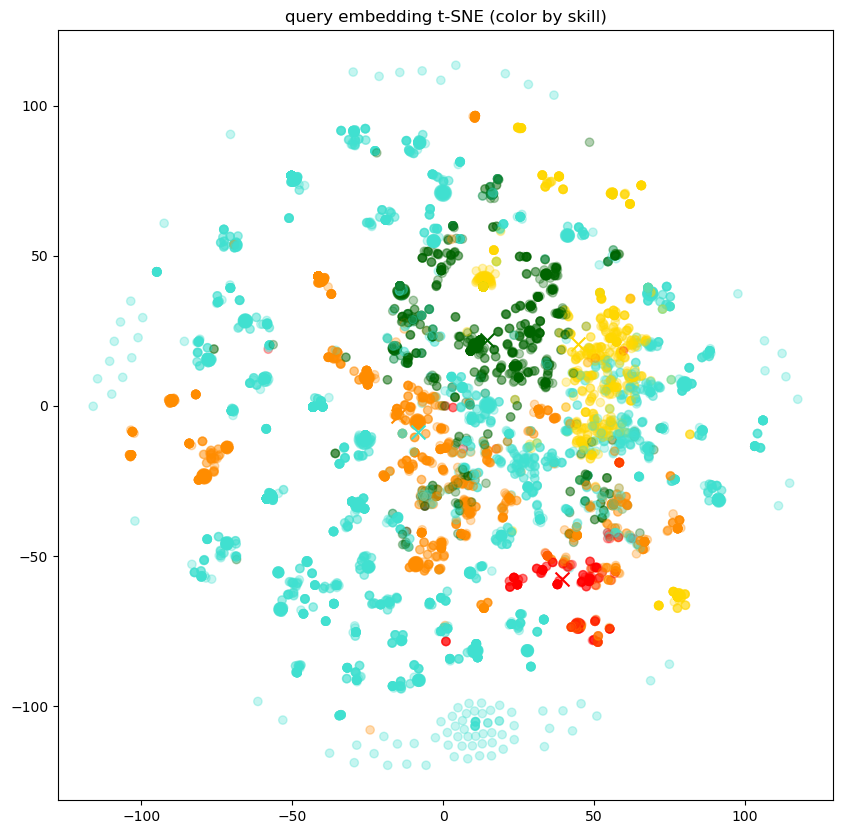

In [101]:
# Visualizing_embeddings_in_2D color by skill
# https://github.com/openai/openai-cookbook/blob/45c6406e8bb42e502d0394a9f1d217e5494ba4a2/examples/Visualizing_embeddings_in_2D.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.manifold import TSNE
from ast import literal_eval

# Load the embeddings
embedding_path = "./data/Tips_query_embedding_tr.csv"
df = pd.read_csv(embedding_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(literal_eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.skill.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.skill-1==score].mean()
    avg_y = np.array(y)[df.skill-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("query embedding t-SNE (color by skill)")
plt.show()

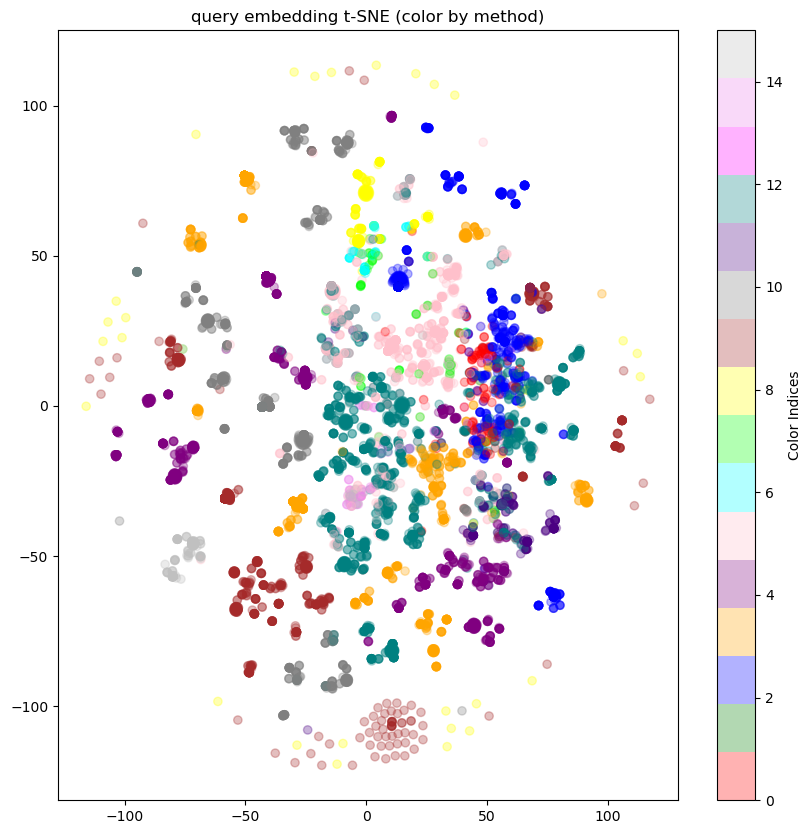

In [145]:
# Visualizing_embeddings_in_2D color by method

color_indices = df.method.values - 1
colors = ["red", "green", "blue", "orange", "purple", "pink",
          "cyan", "lime", "yellow", "brown", "grey", "indigo",
          "teal", "magenta", "violet", "silver"]
cmap = matplotlib.colors.ListedColormap(colors)

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=color_indices, cmap=cmap, alpha=0.3)
plt.colorbar(label='Color Indices')
for score in range(16):
    if np.array(x)[df.method-1==score].all():
        continue
    avg_x = np.array(x)[df.method-1==score].mean()
    avg_y = np.array(y)[df.method-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', s=100)

plt.title("query embedding t-SNE (color by method)")
plt.show()

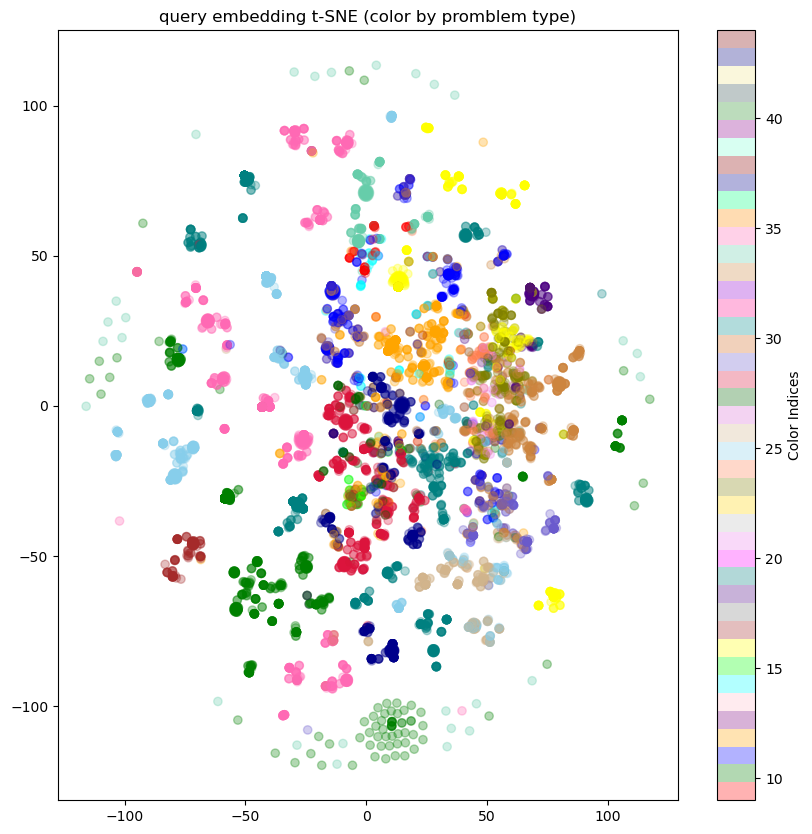

In [149]:
# Visualizing_embeddings_in_2D color by problem type
color_indices = df.문제유형.values - 1
colors = ["red", "green", "blue", "orange", "purple", "pink",
          "cyan", "lime", "yellow", "brown", "grey", "indigo",
          "teal", "magenta", "violet", "silver", "gold", "olive",
          "coral", "skyblue", "tan", "orchid", "darkgreen", "crimson",
          "slateblue", "chocolate", "darkcyan", "deeppink", "darkviolet",
          "peru", "mediumaquamarine", "hotpink", "darkorange", "springgreen",
          "darkblue", "darkred", "aquamarine", "darkmagenta", "forestgreen",
          "darkslategray", "khaki", "navy", "maroon"]
cmap = matplotlib.colors.ListedColormap(colors)

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=color_indices, cmap=cmap, alpha=0.3)
plt.colorbar(label='Color Indices')
for score in range(42):
    if np.array(x)[df.method-1==score].all():
        continue
    avg_x = np.array(x)[df.method-1==score].mean()
    avg_y = np.array(y)[df.method-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', s=100)

plt.title("query embedding t-SNE (color by promblem type)")
plt.show()

마지막으로 Naive Bayes를 활용하여 classification하여보자
1. 질문 column을 vector화 한뒤. 2. TF-IDF matrix로 변환하고 3. NB에 학습시켜 결과를 구한다.

In [359]:
# Applying Naive Bayes (https://wikidocs.net/22892)
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

train_df = pd.read_csv('./data/solvook_handout_tr.csv')
test_df = pd.read_csv('./data/solvook_handout_te.csv') #테스트 데이터 갖고오기

dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_dtm = dtmvector.fit_transform(train_df['질문'].tolist()) # dtm(문서단어 행렬) matrix
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)  # TF-IDF(단어 빈도-역 문서 빈도) matrix
X_test_dtm = dtmvector.transform(test_df['질문'].tolist()) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(X_test_dtm) #DTM을 TF-IDF 행렬로 변환

for col_name in ['skill', 'method', '문제유형']:
    # Naive Bayes
    mod = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    mod.fit(tfidfv, train_df[col_name].tolist())
    predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print(f"{col_name} 정확도:", accuracy_score(test_df[col_name], predicted))

skill 정확도: 0.882865440464666
method 정확도: 0.9002904162633107
문제유형 정확도: 0.8625363020329139


In [360]:
# 문제유형의 중요 keyword 확인
from collections import defaultdict
def get_top_words_per_category(vectorizer, mod, categories, n_words=10):
    top_words = defaultdict(list)
    for cat in categories:
        cat_idx = mod.classes_.tolist().index(cat)
        top_word_indices = mod.feature_log_prob_[cat_idx].argsort()[-n_words:][::-1]
        top_words[cat] = [vectorizer.get_feature_names_out()[i] for i in top_word_indices]    
    return top_words
col_name = 'method'
mod = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
mod.fit(tfidfv, train_df[col_name].tolist())
categories = train_df[col_name].unique()
top_words_per_category = get_top_words_per_category(dtmvector, mod, categories, n_words=10)
top_words_problem_type = pd.DataFrame(top_words_per_category)
top_words_problem_type

,4,13,10,16,8,11,5,15,6,3,9,12,1,7
0,고치시오,부분,이어질,흐름과,것은,문장이,어법을,다른,내용과,완성하시오,제목으로,들어갈,우리말로,요지로
1,틀린,밑줄,순서로,전체,읽고,들어가기에,어휘,가리키는,일치하지,이용하여,가장,말로,쓰시오,가장
2,것을,것은,다음에,문장은,없는,흐름으로,고르시오,대상이,않는,단어를,주제로,빈칸,글을,것은
3,어법상,다음,주어진,관계없는,드러난,보아,적절한,나머지,것은,주어진,것은,것은,읽고,적절한
4,올바르게,어법상,가장,글에서,다음,가장,맞는,넷과,다음,밑줄,적절한,글의,찾아,목적으로
5,골라,글의,글의,없는,글을,주어진,안에서,밑줄,빈칸에,서술형,글의,가장,밑줄,다음
6,밑줄,쓰임이,적절한,관계,변화로,곳을,것은,같은,글의,맞게,다음,적절한,다음,글의
7,부분,않은,것은,다음,가장,적절한,글에서,것은,말로,조건,윗글의,다음,서술하시오,주장으로
8,다음,어색한,글에,대상이,내용으로,곳은,에서,다음,들어갈,보기,것을,연결어구는,해석하시오,주장하는
9,찾아,적절하지,순서는,가리키는,답할,고르시오,알맞은,부분이,가장,영작하시오,고르시오,짝지어진,영어로,필자가


위에서 확인한 주요 keyward를 LLM에게 reference로 준다면 주요 keyward를 가지는 질문들은 쉽게 분류를 할 수 있을거라 추측 할 수 있다.

### prompt 설계 방안  
(https://github.com/openai/openai-cookbook/blob/main/techniques_to_improve_reliability.md)

위 링크에서는 openai에서 prompt 설계에 대한 여러 논문들의 내용(~22.09)들을 요약해서 정리 해두었다.  
논문들의 사용된 알고리즘을 우리 방법에 적용하기엔 힘들 수 있다. 그래서 아래에 내용들을 참조하여 prompt를 설계해보았다.

요약된 주요 technique들을 보면 총 7가지가 존재하였는데. 1,2,3 번을 사용해서 prompt를 구체화 해보았다.
1. Give clearer instructions (보다 명확한 지침 제공)  
2. Split complex tasks into simpler subtasks (복잡한 작업을 더 간단한 하위 작업으로 나누기)  
3. Structure the instruction to keep the model on task (모델이 작업을 계속할 수 있도록 지시를 구조화하세요.)  
4. Prompt the model to explain before answering (모델에게 대답하기 전에 설명하라는 메시지 표시)  
5. Ask for justifications of many possible answers, and then synthesize (여러 가지 가능한 답변에 대한 정당화를 요청한 다음 종합하기)  
6. Generate many outputs, and then use the model to pick the best one (여러 출력을 생성한 다음 모델을 사용하여 가장 적합한 출력 선택하기)  
7. Fine-tune custom models to maximize performance (사용자 지정 모델을 미세 조정하여 성능 극대화)  

가정 1) 하위 작업으로 질문을 분할 하는것이 더 쉬운 task이다.  
가정 2) 각 step의 해결이 다음 step 추론에 도움을 줄 수 있다.  

skill(기술) > comprehension ability(이해 능력) 1번에 의해 약간 수정하였다.

instruction: 
(+ 문제, 보기, 선지를 제시)를 참조하여 아래의 순서에 따라 질문을 답하여라
1. 주어진 문제를 풀고 이유를 들어 정답을 말해라.
2. 1번 문제를 풀기 위해 필요한 comprehension ability(이해능력)이 무엇인가?
3. 2번의 comprehension ability(이해능력)을 참고하여 1번 문제를 풀기 위해 사용된 method(방법)이 무엇인가?
4. 2,3번의 comprehension ability와 method를 참고하여 제시된 문제유형을 맞춰라.

여기서 추가적으로 skill list와 method list에 대한 질문도 넣을 수 있다.  
가정 3) skill list와 method list의 defention을 알고 있으면 더 잘 맞출 수 있다.

instruction: 
(+ 문제, 보기, 선지를 제시)를 참조하여 아래의 순서에 따라 질문을 답하여라
1. 주어진 문제를 풀고 이유를 들어 정답을 말해라.
2. 주어진 comprehension ability list 와 method list에 대해서 각 list 원소별로 어떤 능력 혹은 방법인지 설명해라. 
3. 1번 문제를 풀기 위해 필요한 comprehension ability(이해능력)이 무엇인가?
4. 3번의 comprehension ability(이해능력)을 참고하여 1번 문제를 풀기 위해 사용된 method(방법)이 무엇인가?
5. 3,4번의 comprehension ability와 method를 참고하여 제시된 문제유형을 맞춰라.


### prompt test
100개만 sampling 해서 gpt3.5-turbo에 대해 test해보자

In [37]:
# new dataset preprocessing
import os
import json 
import pandas as pd

xlsx_file_path = './data/100_Solvook_handout_DB_english_0825.xlsx' # put your path
df = pd.read_excel(xlsx_file_path)

df_drop= df.dropna(subset=['질문', '본문', '분류체계 시트 > \nskill # , method #', '분류체계 시트 > \n문제유형 #'])
selected_columns = ['본문', '조건', '선지', '정답', '질문', '분류체계 시트 > \nskill # , method #', '분류체계 시트 > \n문제유형 #']
new_df = df_drop[selected_columns]
new_df = new_df.reset_index(drop=True)
new_column_names = {
    '분류체계 시트 > \n문제유형 #': '문제유형',
    '분류체계 시트 > \nskill # , method #': 's&m'
}
new_df = new_df.rename(columns=new_column_names)
new_df

,본문,조건,선지,정답,질문,s&m,문제유형
0,"Girl: Minho, you look tired.\nBoy: I went to b...",NaN,(A) : ________________________________________...,(A) Was there any particular reason? Did you h...,"1. 다음 글의 대화의 빈칸 (A), (B)에 들어갈 우리말을 영작하시오.","{ ""skill"": [3], ""method"": [3] }",24.0
1,Having a healthy lifestyle is important. It ca...,Q: What do we have to do to reduce our risk of...,정답 : _________________________________________...,We have to eat a diet rich in vegetables and f...,2. 다음 글을 읽고 물음에 영어로 완전한 문장으로 답하시오.,"{ ""skill"": [3], ""method"": [1] }",22.0
2,"W: Dr. Dawn, thank you for agreeing to do this...",According to Dr. Dawn’s tips for improving you...,\n(A) : ______________________________________...,(A) not to hide your feeling \n(B) to help others,"3. 다음 대화를 한 문장으로 요약하고자 한다. 빈칸 (A), (B) 에 들어갈 어...","{ ""skill"": [4], ""method"": [4] }",20.0
3,"Hello, everyone. Welcome to the TV show, Healt...",NaN,① The title of the TV show is Healthy Life. \n...,①,4. 다음 글의 내용과 일치하는 것은?,"{ ""skill"": [5], ""method"": [6] }",12.0
4,"Hello, I'm Susan. I'm a professional personal ...",NaN,"① Be Smart, Be Healthy \n② Exercise Well \n③ M...",②,5. 위 글의 제목으로 가장 알맞은 것은?,"{ ""skill"": [4], ""method"": [9] }",35.0
...,...,...,...,...,...,...,...
10325,Have you ever slipped and fallen in school? It...,NaN,__________________________,They asked students to estimate how many class...,68. 다음 글의 밑줄 친 부분을 알맞게 영작하시오.,"{ ""skill"": [4], ""method"": [10] }",19.0
10326,"If you were trying to lose weight, what would ...",The researchers monitored the hand movements o...,NaN,③,69. 다음 글이 들어갈 가장 알맞은 위치는?,"{ ""skill"": [4], ""method"": [11] }",36.0
10327,Great ideas do not come by chance. They may so...,NaN,NaN,"arise, require, Take, fell, to think, have won...",70. 다음 글에서 어법상 알맞은 것은?,"{ ""skill"": [2], ""method"": [5] }",26.0
10328,We often assume we see our physical surroundin...,(A) This difference in perception showed up in...,➀ (A) - (C) - (B) \n➁ (B) - (A) - (C)\n➂ (B) -...,④,71. 다음 글에 이어질 알맞은 글의 순서는?,"{ ""skill"": [4], ""method"": [10] }",11.0


In [38]:
# remove prefix numbering 
import re
def remove_non_alphanumeric_prefix(input_string):
    pattern = '[가-힣a-zA-Z]'
    match = re.search(pattern, input_string)
    if match: cleaned_string = input_string[match.start():]
    else:     cleaned_string = input_string
    return cleaned_string

for col in ['본문','질문','선지','조건','정답']:
    try:
        new_df[col]=new_df[col].apply(lambda x: re.sub('___+','___',x)) # replace _____(long) > __(short)
    except:
        pass
new_df['질문'] = new_df['질문'].apply(remove_non_alphanumeric_prefix) 

In [39]:
# extract_skill_method ex) { "skill": [3], "method": [3] } > skill: 3 , method: 3
def extract_skill_method(s_and_m):
    try:
        s_and_m_dict = json.loads(s_and_m.replace("'", "\""))
        skill = s_and_m_dict['skill'][0] if 'skill' in s_and_m_dict else None
        method = s_and_m_dict['method'][0] if 'method' in s_and_m_dict else None
        return skill, method
    except:
        return None, None

new_df[['skill', 'method']] = new_df['s&m'].apply(extract_skill_method).apply(pd.Series) 
new_df[['skill','method']] = new_df[['skill','method']].astype(int)

new_df = new_df.drop(columns=['s&m'])
new_df = new_df.reset_index(drop=True)

In [41]:
# save tr/val/te split
from sklearn.model_selection import train_test_split
tr, te_0 = train_test_split(new_df, 
                            stratify=new_df[['skill','method']],
                            test_size=0.2,
                            random_state=1)
# val / te
val, te  = train_test_split(te_0,
                            stratify=te_0[['skill','method']],
                            test_size=0.5,
                            random_state=1)
print(f'train split: {tr.shape}')
print(f'validation split: {val.shape}')
print(f'test split: {te.shape}')

data_path = './data'
tr.to_csv(os.path.join(data_path,'solvook_handout_tr.csv'), encoding='utf-8-sig')
val.to_csv(os.path.join(data_path,'solvook_handout_val.csv'), encoding='utf-8-sig')
te.to_csv(os.path.join(data_path,'solvook_handout_te.csv'), encoding='utf-8-sig')

train split: (8264, 8)
validation split: (1033, 8)
test split: (1033, 8)


In [196]:
# sampling 100 qeury for test 
import pandas as pd

sample_size = 100
random_sample = new_df.sample(n=sample_size, random_state=42)  
question_list = random_sample['질문'].values.tolist()
question_list

['다음 글을 통해 알 수 없는 것은?',
 '나)는 (가) 내용에 대한 ‘VR indoor bike’에 대한 광고문의 일부분이다. 빈칸에 들어갈 말을 (가)에서 찾아 쓰시오. (필요시 단어의 형태를 바꿀 것)',
 '다음 글의 밑줄 친 우리말을 <보기>의 단어들을 활용하여 <조건>에 맞게 영작하시오.',
 '글의 흐름으로 보아, 주어진 문장이 들어가기에 가장 적절한 것은?',
 '다음 글의 괄호 (A),(B),(C) 안에서 문맥상 맞는 낱말로 가장 적절한 것은?',
 '다음 글의 내용과 일치하지 않는 것은?',
 '다음 글을 읽고 물음에 영어로 완전한 문장으로 답하시오.',
 '적절한 어휘/어법을 고르시오.',
 '주어진 글 다음에 이어질 글의 순서로 가장 적절한 것을 고르시오.',
 '다음 글의 흐름으로 보아, 주어진 문장이 들어가기에 가장 적절한 곳은?',
 '다음 글의 밑줄 친 부분 중, 어법상 틀린 것을 두 개 골라 올바르게 고치시오.',
 '다음 글의 주제로 가장 적절한 것은?',
 '주어진 글 (A)에 이어질 내용을 순서에 맞게 배열한 것으로 가장 적절한 것은?',
 '다음 글의 빈칸 (A), (B), (C)에 들어갈 말로 가장 적절한 것은?',
 '다음 글에서 확인할 수 없는 내용은?',
 '다음 글의 밑줄 친 부분 중, 어법상 틀린 것을 두 개 골라 올바르게 고치시오.',
 '다음 글에서 Hummingbird에 대해 다른 새들이 느끼는 감정으로 가장 적절한 것은?',
 'A), (B), (C)의 각 괄호 안에서 문맥에 맞는 낱말로 가장 적절한 것은?',
 '위 글의 괄호 (A), (B), (C) 안에서 문맥에 맞는 낱말로 가장 적절한 것은?',
 '다음 글의 밑줄 친 부분 중, 어법상 틀린 것을 두 개 골라 올바르게 고치시오.',
 '서술형 ①] 주어진 단어를 이용하여 밑줄 친 (가)를 완성하시오.',
 '다음 밑줄 친 ①~⑥ 중 어법상 잘못된 것 2개를 찾아 번호를 쓰고 잘못된 부분을 바르게 고쳐 쓰시오.',
 '밑줄 친 ➀~➄ 중 어법상 잘

In [262]:
skill_list = random_sample.skill.tolist()
method_list = random_sample.method.tolist()
type_list = random_sample.문제유형.tolist()

# additional data list 
passage_list = random_sample.본문.tolist()
condition_list = random_sample.조건.tolist()
options_list = random_sample.선지.tolist()
answer_list = random_sample.정답.tolist()

In [ ]:
# candidates for skill, method, reference (newly defined after 8/1)
skill = ['vocabulary', 'grammar', 'expression', 'content', 'context']
method = ['translate the sentence', 'write or find the right word', 'write a sentence', 'correct the underlined',
        'find the all-true', 'find the matching / the mismatched', 'find the main idea', 'make an analogy',
        'find the right title', 'arrange the sequence', 'position the sentence', 'find the right conjunction',
        'find the correct / find the incorrect', 'correct the incorrect', 'find the same / find the different',
        'find the irrelevant']
reference = ['vocabulary:맞는,문맥에,안에서,낱말로,괄호', 
        'grammar:어법을,어휘,고르시오,적절한,어법상', 
        'expression:이용하여, 완성하시오,단어를,주어진,밑줄',
        'content:글의,가장,적절한,다음,주어진', 
        'context:내용과,것은,일치하지,않는,글의', 
        'translate the sentence:우리말로,쓰시오,찾아,밑줄,적으시오',
        'write a sentence:이용하여,완성하시오,단어를,주어진',
        'correct the underlined:고치시오,틀린,것을,어법상,올바르게',
        'find the all-true:어법을,어휘,고르시오,적절한,맞는',
        'find the matching / the mismatched:내용과,일치하지,않는,것은,글의',
        'find the main idea:요지로,가장,적절한,것은,목적으로',
        'make an analogy:것은,없는,읽고,가장,글을',
        'find the right title:제목으로,주제로,가장,적절한,것은', 
        'arrange the sequence:이어질,순서로,다음에,주어진,가장', 
        'position the sentence:문장이,들어가기에,흐름으로,보아,가장', 
        'find the right conjunction:들어갈,말로,빈칸,것은,가장', 
        'find the correct / find the incorrect:부분,것은,다음,어법상,밑줄', 
        'find the same / find the different:다른,같은,대상이,가르키는,밑줄', 
        'find the irrelevant:흐름과,전체,문장은,관계없는,글에서']
problem_type = {10: 'gist of content(Include summary)', 11:'Order of writing', 12:'match content', 13:'content inconsistency', 15:'Content analogy', 16:"Find another usage", 17:"Korean-English Interpreter(offer conditions)", 18:"Find irrelevant sentences", 19:"rearrangement of words", 20:"Correct the underlined part(grammar)", 22:"descriptive(written in English)", 24:"Descriptive type (Conditional English composition)", 25:"Descriptive(written in Korean)", 26:'Choose the correct one from 2 or more options(grammar)', 27:"Choose the correct one from 2 or more options(Vocabulary)", 28:"Find something that fits grammatically", 29:"Find something wrong with grammar", 30:"Find linking words", 34:"Find the right vocabulary", 35:"Find the right title/topic", 36:"insert the given sentence", 38:"Find the wrong vocabulary", 42:"Find the same usage", 44:"Find the same vocabulary",}
problem_type_tonum = {v:k for k, v in problem_type.items()}
problem_type_list = list(problem_type.values())

model_name = 'gpt-3.5-turbo-0613'
model16k_name = 'gpt-3.5-turbo-16k-0613'
price = 0.0015
os.makedirs('./data/test', exist_ok = True)

In [151]:
# numbered candidates for skill, method
skill_numbering = ['1. vocabulary', '2. grammar', '3. expression', '4. content', '5. context']
method_numbering = ['1. translate the sentence', '2. write or find the right word', '3. write a sentence', '4. correct the underlined',
        '5. find the all-true', '6. find the matching / the mismatched', '7. find the main idea', '8. make an analogy',
        '9. find the right title', '10. arrange the sequence', '11. position the sentence', '12. find the right conjunction',
        '13. find the correct / find the incorrect', '14. correct the incorrect', '15. find the same / find the different',
        '16. find the irrelevant']

In [158]:
# calculate the number of tokens in sentence
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
    """Return the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif "gpt-3.5-turbo" in model:
        print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
    elif "gpt-4" in model:
        print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens


In [275]:
# plot_heatmap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def plot_heatmap(label, preds, label_name='Skill'):
    cm = confusion_matrix(label, preds)
    unique_list = np.unique(np.array([label, preds]))
    accuracy = sum([cm[i, i] for i in range(len(unique_list))]) / len(unique_list)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=unique_list, yticklabels=unique_list)
    plt.title(f"Accuracy: {accuracy:.2f}")
    plt.xlabel('Predict')
    plt.ylabel(label_name)
    plt.title(f'{label_name} Confusion Matrix')
    plt.show()
    
    print(classification_report(label, preds))

#### Test1: base naive prompt

In [304]:
q_list_test1 = []
for question in question_list:
    prompt = f"Skill은 질문텍스트를 이해해야 하는 학습내용을 의미하고, Method는 Skill을 습득하는 방법을 담은 정보이다. Skill과 Method의 분류 리스트는 다음과 같다.\n" \
             f"Skill: {skill}\nMethod: {method}\n" \
             f"다음 질문텍스트의 Skill과 Method는 각각 무엇인지 하나씩 맞춰보세요.\n" \
             f"질문 : {question}"
    q_list_test1.append(prompt)
q_list_test1[0]

"Skill은 질문텍스트를 이해해야 하는 학습내용을 의미하고, Method는 Skill을 습득하는 방법을 담은 정보이다. Skill과 Method의 분류 리스트는 다음과 같다.\nSkill: ['vocabulary', 'grammar', 'expression', 'content', 'context']\nMethod: ['translate the sentence', 'write or find the right word', 'write a sentence', 'correct the underlined', 'find the all-true', 'find the matching / the mismatched', 'find the main idea', 'make an analogy', 'find the right title', 'arrange the sequence', 'position the sentence', 'find the right conjunction', 'find the correct / find the incorrect', 'correct the incorrect', 'find the same / find the different', 'find the irrelevant']\n다음 질문텍스트의 Skill과 Method는 각각 무엇인지 하나씩 맞춰보세요.\n질문 : 다음 글을 통해 알 수 없는 것은?"

In [306]:
res_list_test1 = []
n_tokens = 0
for query in q_list_test1:
    messages = [{'role': 'user', 'content': query}]
    if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
        res = openai.ChatCompletion.create(model = model16k_name, messages = messages, max_tokens = 500)
        n_tokens += res['usage']['total_tokens']*2
    else:
        res = openai.ChatCompletion.create(model = model_name, messages = messages, max_tokens = 500)
        n_tokens += res['usage']['total_tokens']
    res_list_test1.append(res['choices'][0]['message']['content'])
print(f'usage : {n_tokens/1000*price:.02f}$')
res_list_test1[:2]

usage : 0.04$


['Skill: content\nMethod: find the irrelevant',
 'Skill: content\nMethod: write a sentence']

In [307]:
res_list_test1

['Skill: content\nMethod: find the irrelevant',
 'Skill: content\nMethod: write a sentence',
 'Skill: grammar\nMethod: correct the underlined',
 'Skill: context\nMethod: arrange the sequence',
 'Skill: vocabulary\nMethod: write or find the right word\n\n질문 : 다음 글의 괄호 (A),(B),(C) 안에서 문맥상 맞는 낱말로 가장 적절한 것은?\n\n이 질문은 주어진 문맥에서 가장 알맞은 단어를 선택하는 문제로, Skill은 vocabulary(어휘력)이고, Method는 write or find the right word(적절한 단어를 쓰거나 찾는 방법)입니다.',
 'Skill: content\nMethod: find the mismatched',
 'Skill: content\nMethod: write a sentence',
 'Skill: vocabulary/grammar\nMethod: write or find the right word',
 'Skill: context\nMethod: arrange the sequence',
 'Skill: content\nMethod: arrange the sequence',
 'Skill: grammar\nMethod: correct the underlined',
 'Skill: content\nMethod: find the main idea',
 'Skill: content\nMethod: arrange the sequence\n\n질문 : 주어진 글 (A)에 이어질 내용을 순서에 맞게 배열한 것으로 가장 적절한 것은?\n\n',
 'Skill: context\nMethod: find the right word\n\n질문의 Skill은 context입니다. 문맥을 이해하고 적절한 단어를 찾아내는 것이 필요합니다. 

정답 출력 양식  
1. skill / method 뒤에 skill_name / method_name으로 답변 ex) 'Skill: content\nMethod: write a sentence'  
2. 1번 뒤에 질문이 있는 경우가 있음. 이 질문은 물어본 질문과 같을 수도 있고 다를 수도 있음 ex) 'Skill:  ... sentence 질문 : 주어진 글 (A)... 가장 적절한 것은?\n\n',  
3. 1번 뒤에 추가 설명하는 경우 ex) "Skill: ... incorrect\n\n질문의 Skill은 'grammar'이며, Method는 'find the incorrect'입니다.",  

4. 답변을 거부하는 경우 존재 ex) '질문에 대한 정보가 부족하여 Skill과 Method를 판단할 수 없습니다. 추가 정보가 있다면 알려주세요.',     
    => 원래 질문 :'다음 빈칸 (A), (B), (C)에 들어갈 말로 순서대로 바르게 짝지은 것은?'  
5. 이상한 답변을 하는 경우 존재 ex) .. . 해야 할까요? 어떤 스킬과 메소드를 사용해야 영어 실력이 향상될까요?\n\nSkill: content\nMethod: find the right method for improving English proficiency',  
    => 원래 질문 : '다음 글의 내용과 일치하는 것은?'  

=> 대부분에 경우에 skill_name / method_name이 존재(4,5번은 질문만으로 답변하기 어려운 경우 인듯 어쩔 수 없이 오답 처리)

정답 채점 방식  
1. 소문자로 변환
2. 정규표현식을 사용하여 해당 skill_name과 method_name이 존재하는지 파악
2. 추가설명을 위해 같은 name을 여러번 언급할 수 있으므로 np.unique사용 하여 각 skill, method 별로 한번씩 언급하는지 파악
3. 그 외의 경우: skill 은 6번 method는 17번(range 밖)  

In [372]:
def pred_parse(string , pats = ['vocabulary', 'grammar', 'expression', 'content', 'context']):
    txt_preds = []
    for idx, pat in enumerate(pats):
        for match in re.finditer(pat, string):
            txt_preds.append(match.group())
    txt_preds = np.unique(txt_preds) # 중복 처리
    if len(txt_preds) == 1:         # 1개 찾은경우
        num_pred = pats.index(txt_preds[0])
    else:                           # 예외 skill label: 5
        num_pred = len(pats)
    return txt_preds, num_pred

txt_preds, num_pred = pred_parse( "Skill: grammar\nMethod: find the incorrect\n\n질문의 Skill은 'grammar'이며, Method는 'find the incorrect'입니다.".lower(), skill)
print(txt_preds, num_pred)
txt_preds, num_pred = pred_parse( "Skill: grammar\nMethod: find the incorrect\n\n질문의 Skill은 'grammar'이며, Method는 'find the incorrect'입니다.".lower(), method)
print(txt_preds, num_pred)
print(True) if 'find the incorrect' in method else False

['grammar'] 1
[] 16


False

In [373]:
skill_preds_test1 = []
method_preds_test1 = []
for string in res_list_test1:
    _, s = pred_parse(string.lower(), skill)
    _, m = pred_parse(string.lower(), method)
    skill_preds_test1.append(s+1)
    method_preds_test1.append(m+1)
print(skill_preds_test1[0], method_preds_test1[0])
print(skill_preds_test1[1], method_preds_test1[1])
data = [row for row in zip(res_list_test1, skill_list, method_list, skill_preds_test1, method_preds_test1)]
df_test1 = pd.DataFrame(data, columns=['Response', 'label_skill', 'label_method','pred_skill', 'pred_method'])
df_test1.to_csv("./data/test/test_1.csv")

4 16
4 3


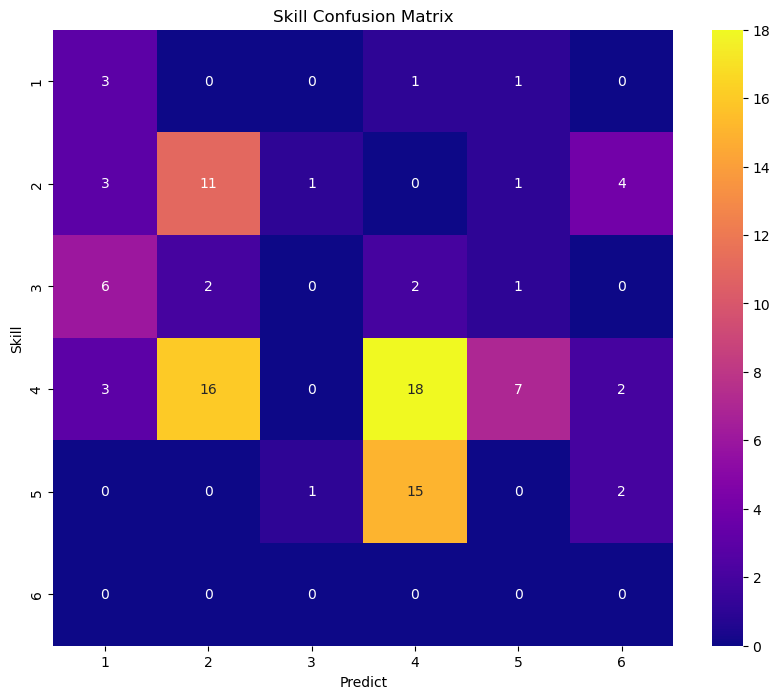

              precision    recall  f1-score   support

           1       0.20      0.60      0.30         5
           2       0.38      0.55      0.45        20
           3       0.00      0.00      0.00        11
           4       0.50      0.39      0.44        46
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00         0

    accuracy                           0.32       100
   macro avg       0.18      0.26      0.20       100
weighted avg       0.32      0.32      0.31       100



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [374]:
plot_heatmap(skill_list, skill_preds_test1, 'Skill')

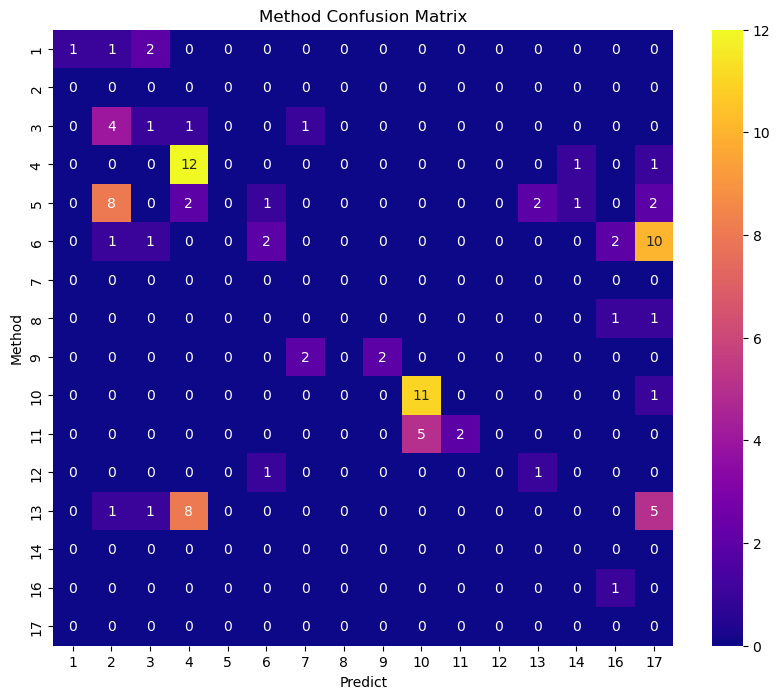

              precision    recall  f1-score   support

           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         0
           3       0.20      0.14      0.17         7
           4       0.52      0.86      0.65        14
           5       0.00      0.00      0.00        16
           6       0.50      0.12      0.20        16
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       1.00      0.50      0.67         4
          10       0.69      0.92      0.79        12
          11       1.00      0.29      0.44         7
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00         0
          16       0.25      1.00      0.40         1
          17       0.00      0.00      0.00         0

    accuracy                           0.32       100
   macro avg       0.32   

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppDat

In [375]:
plot_heatmap(method_list, method_preds_test1, 'Method')

#### Test1-2: base naive prompt(numbering)
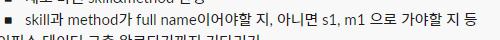

In [198]:
q_list_test1_2 = []
for question in question_list:
    prompt = f"Skill은 질문텍스트를 이해해야 하는 학습내용을 의미하고, Method는 Skill을 습득하는 방법을 담은 정보이다. Skill과 Method의 분류 리스트는 다음과 같다.\n" \
             f"Skill: {skill_numbering}\nMethod: {method_numbering}\n" \
             f"다음 질문의 Skill과 Method는 각각 무엇인지 하나씩 골라 정답 : skill.number, label.number의 형식으로 답해줘\n" \
             f"질문 : {question}"
    q_list_test1_2.append(prompt)
q_list_test1_2[0]

"Skill은 질문텍스트를 이해해야 하는 학습내용을 의미하고, Method는 Skill을 습득하는 방법을 담은 정보이다. Skill과 Method의 분류 리스트는 다음과 같다.\nSkill: ['1. vocabulary', '2. grammar', '3. expression', '4. content', '5. context']\nMethod: ['1. translate the sentence', '2. write or find the right word', '3. write a sentence', '4. correct the underlined', '5. find the all-true', '6. find the matching / the mismatched', '7. find the main idea', '8. make an analogy', '9. find the right title', '10. arrange the sequence', '11. position the sentence', '12. find the right conjunction', '13. find the correct / find the incorrect', '14. correct the incorrect', '15. find the same / find the different', '16. find the irrelevant']\n다음 질문의 Skill과 Method는 각각 무엇인지 하나씩 골라 정답 : skill.number, label.number의 형식으로 답해줘\n질문 : 다음 글을 통해 알 수 없는 것은?"

In [199]:
res_list_test1_2 = []
n_tokens = 0
for query in q_list_test1_2:
    messages = [{'role':'user', 'content': query}]
    if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
        res = openai.ChatCompletion.create(model = model16k_name, messages = messages, max_tokens = 500)
        n_tokens += res['usage']['total_tokens']*2
    else:
        res = openai.ChatCompletion.create(model = model_name, messages = messages, max_tokens = 500)
        n_tokens += res['usage']['total_tokens']
    res_list_test1_2.append(res['choices'][0]['message']['content'])
print(f'usage : {n_tokens/1000*price:.02f}$')
res_list_test1_2[:2]

usage : 0.05$


['Skill: 5. context\nMethod: 7. find the main idea', 'skill.3, method.2']

In [200]:
res_list_test1_2

['Skill: 5. context\nMethod: 7. find the main idea',
 'skill.3, method.2',
 'Skill: 3. expression\nMethod: 4. correct the underlined',
 '답 : Skill.5, Method.7',
 'Skill: 5. context\nMethod: 2. write or find the right word',
 'Skill: 4. content\nMethod: 15. find the same / find the different',
 'skill.4, method.3',
 '답변: skill.1, method.2',
 'Skill: 4. content\nMethod: 10. arrange the sequence',
 'Skill: 4. content\nMethod: 11. position the sentence',
 'Skill: 2. grammar\nMethod: 4. correct the underlined',
 'Skill: 5. context\nMethod: 7. find the main idea',
 'skill.4, method.10',
 '정답 : skill.4, method.10',
 'Skill: 4. content\nMethod: 15. find the same / find the different',
 'Skill: 3. expression\nMethod: 13. find the correct / find the incorrect',
 'skill.4, method.7',
 'Skill: 3. expression \nMethod: 2. write or find the right word',
 'Skill: 5. context\nMethod: 2. write or find the right word',
 'Skill: 2. grammar\nMethod: 4. correct the underlined',
 '정답 : skill.1, method.3',
 "

정답 출력 양식  
1. skill / method 뒤에 numbering으로 답변 ex) 'skill.4, method.3'  
2. 정답/답변 뒤에 답변  ex)'답 : 1. vocabulary, 2. grammar',  
3. 번호만 2가지 답변 ex) 정답 : 4, 15'    
=> 모든 경우에 번호를 포함하기 때문에 번호갯수로 나누어서 집계한다(번호 없이 답하는것은 없음)  

정답 채점 방식  
1. number가 2가지인 경우: 첫번째 번호는 skill 두번째 번호는 method  
2. 그 외의 경우: skill 은 6번 method는 17번(range 밖)  



In [336]:
def pred_parse(string):
    num_preds = []
    numbers = re.findall(r'\d+', string)
    if len(numbers) == 2 and int(numbers[0])<=5 and int(numbers[1])<=16:   # 2개 찾은경우
        num_preds = numbers
    else:                   # 그외의 경우 skill label: 6, method label: 17
        num_preds = [6, 17]
    return num_preds
preds_test1_2 = pred_parse('Skill: 6. context\nMethod: 5. find the main idea'.lower())
print(preds_test1_2)

[6, 17]


In [337]:
skill_preds_test1_2 = []
method_preds_test1_2 = []
for string in res_list_test1_2:
    s, m = pred_parse(string)
    skill_preds_test1_2.append(int(s))
    method_preds_test1_2.append(int(m))
print(skill_preds_test1_2[0], method_preds_test1_2[0])
print(skill_preds_test1_2[1], method_preds_test1_2[1])
data = [row for row in zip(res_list_test1_2, skill_list, method_list, skill_preds_test1_2, method_preds_test1_2)]
df_test1_2 = pd.DataFrame(data, columns=['Response', 'label_skill', 'label_method','pred_skill', 'pred_method'])
df_test1_2.to_csv("./data/test/test_1_2.csv")

5 7
3 2


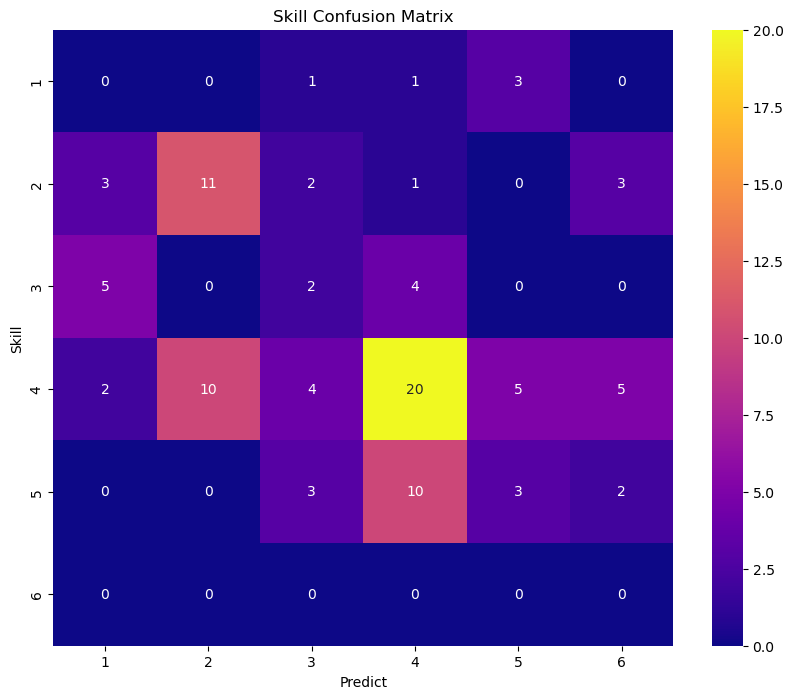

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.52      0.55      0.54        20
           3       0.17      0.18      0.17        11
           4       0.56      0.43      0.49        46
           5       0.27      0.17      0.21        18
           6       0.00      0.00      0.00         0

    accuracy                           0.36       100
   macro avg       0.25      0.22      0.23       100
weighted avg       0.43      0.36      0.39       100



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [277]:
plot_heatmap(skill_list, skill_preds_test1_2, 'Skill')

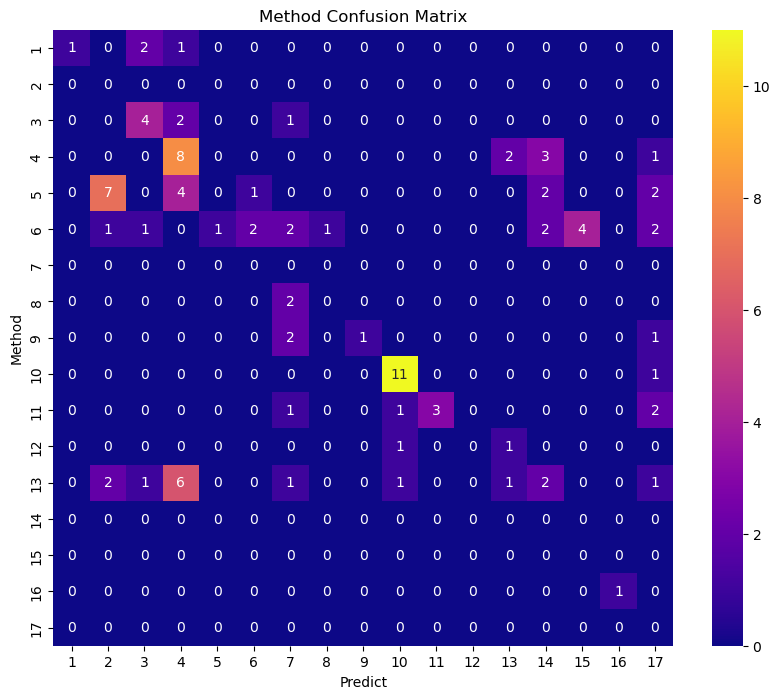

              precision    recall  f1-score   support

           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         0
           3       0.50      0.57      0.53         7
           4       0.38      0.57      0.46        14
           5       0.00      0.00      0.00        16
           6       0.67      0.12      0.21        16
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       1.00      0.25      0.40         4
          10       0.79      0.92      0.85        12
          11       1.00      0.43      0.60         7
          12       0.00      0.00      0.00         2
          13       0.25      0.07      0.11        15
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         0

    accuracy              

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppDat

In [301]:
plot_heatmap(method_list, method_preds_test1_2, 'Method')

#### Test2 : base + reference(by Naive Bayes Classification)
위에서 사용했던 NB의 keyward를 뽑아 reference로 주는 실험이다.

In [347]:
q_list_test2 = []
for question in question_list:   
    prompt = f"Skill은 질문텍스트를 이해해야 하는 학습내용을 의미하고, Method는 Skill을 습득하는 방법을 담은 정보이다. Skill과 Method의 분류 리스트는 다음과 같다.\n " \
             f"Skill: {skill}\n Method: {method}\n" \
             f"Reference는 skill과 method의 분류 중요도가 높은 단어이고 다음과 같다.\n" \
             f"Reference : {reference}\n" \
             f"Reference의 단어에 집중하여 다음 질문텍스트의 Skill과 Method는 각각 무엇인지 하나씩 맞춰보세요.\n" \
             f"질문 : {question}"
    q_list_test2.append(prompt)

q_list_test2[0]

"Skill은 질문텍스트를 이해해야 하는 학습내용을 의미하고, Method는 Skill을 습득하는 방법을 담은 정보이다. Skill과 Method의 분류 리스트는 다음과 같다.\n Skill: ['vocabulary', 'grammar', 'expression', 'content', 'context']\n Method: ['translate the sentence', 'write or find the right word', 'write a sentence', 'correct the underlined', 'find the all-true', 'find the matching / the mismatched', 'find the main idea', 'make an analogy', 'find the right title', 'arrange the sequence', 'position the sentence', 'find the right conjunction', 'find the correct / find the incorrect', 'correct the incorrect', 'find the same / find the different', 'find the irrelevant']\nReference는 skill과 method의 분류 중요도가 높은 단어이고 다음과 같다.\nReference : ['vocabulary:맞는,문맥에,안에서,낱말로,괄호', 'grammar:어법을,어휘,고르시오,적절한,어법상', 'expression:이용하여, 완성하시오,단어를,주어진,밑줄', 'content:글의,가장,적절한,다음,주어진', 'context:내용과,것은,일치하지,않는,글의', 'translate the sentence:우리말로,쓰시오,찾아,밑줄,적으시오', 'write a sentence:이용하여,완성하시오,단어를,주어진', 'correct the underlined:고치시오,틀린,것을,어법상,올바르게', 'find the all-true:어법을,어휘,고르시오,적

In [348]:
res_list_test2 = []
n_tokens = 0
for query in q_list_test2:
    messages = [{'role':'user', 'content': query}]
    if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
        res = openai.ChatCompletion.create(model = model16k_name, messages = messages, max_tokens = 500)
        n_tokens += res['usage']['total_tokens']*2
    else:
        res = openai.ChatCompletion.create(model = model_name, messages = messages, max_tokens = 500)
        n_tokens += res['usage']['total_tokens']
    res_list_test2.append(res['choices'][0]['message']['content'])
print(f'usage : {n_tokens/1000 * price:.02f}$')
res_list_test2[:2]

usage : 0.13$


['Reference에서는 "find the irrelevant"라는 Method가 해당 질문의 답을 찾을 수 있을 것으로 보입니다. 따라서 해당 질문의 Skill은 "content"이고, Method는 "find the irrelevant"입니다.',
 'Skill: content, Method: find the right conjunction']

In [361]:
res_list_test2.index( "Reference를 참고하면, 'correct the underlined'라는 Method가 어법상 잘못된 부분을 찾는 방법을 의미한다고 볼 수 있습니다. 따라서, 문제에서 밑줄 친 부분에서 잘못된 어법을 찾는 Skill과 Method는 'grammar'과 'correct the underlined'입니다.\n\n따라서, 질문의 Skill은 'grammar'이고 Method는 'correct the underlined'입니다.")
print(question_list[22])
method[method_list[22]]

밑줄 친 ➀~➄ 중 어법상 잘못된 것은?


'correct the incorrect'

In [349]:
res_list_test2

['Reference에서는 "find the irrelevant"라는 Method가 해당 질문의 답을 찾을 수 있을 것으로 보입니다. 따라서 해당 질문의 Skill은 "content"이고, Method는 "find the irrelevant"입니다.',
 'Skill: content, Method: find the right conjunction',
 'Skill: vocabulary\nMethod: translate the sentence',
 'Skill: context\nMethod: position the sentence',
 'Skill: context\nMethod: write or find the right word',
 "해당 질문에 대한 Skill은 'content'이며 Method는 'find the irrelevant'입니다.",
 'Skill: content\nMethod: write a sentence',
 'Skill: vocabulary or grammar\nMethod: choose the right word or choose the correct grammar',
 'Skill: content\nMethod: arrange the sequence',
 'Skill: context\nMethod: position the sentence',
 'Skill: grammar\nMethod: correct the incorrect\n\n정답은 문장의 어법상 틀린 부분을 찾아서 올바르게 고치는 방법을 사용해야 합니다.',
 'Skill: content\nMethod: find the main idea',
 'Skill: content\nMethod: arrange the sequence',
 'Skill: context\nMethod: find the right conjunction',
 'Skill: content\nMethod: find the irrelevant',
 'Skill: grammar\nMethod: correct the i

정답 출력 양식  
1. skill / method 뒤에 skill_name / method_name으로 답변 ex) 'Skill: vocabulary\nMethod: translate the sentence',
2. 1번 뒤에 추가 설명하는 경우 ex)  "Skill: ... 텍스트에서는 어법상 틀린 부분을 찾아서 올바르게 고쳐야하는 스킬이 ... 부분을 고치는 방법(Method)은 'correct the incorrect'입니다.",  
3. 반복 하는 경우 ex) 'Method는 "write a sentence"이므로, Skill은 "expression"이고 Method는 "write a sentence"입니다.'
4. reference를 참조하는 경우 ex)  'Skill: ... Reference에는 "correct the underlined: 고치시오, 틀린, 것을, 어법상, 올바르게"라는 단어가 포함되어 있습니다. 따라서, 이 질문의 Skill은 grammar이고, Method는 correct the underlined입니다.' > 그럼에도 틀림, 원래 질문은 '밑줄 친 ➀~➄ 중 어법상 잘못된 것은?'이고 정답은 'correct the incorrect' 이다. > 할루시네이션이 생길 수도 있음  
=> 대부분에 경우에 skill_name / method_name이 존재

정답 채점 방식(1번과 같음)
1. 소문자로 변환
2. 정규표현식을 사용하여 해당 skill_name과 method_name이 존재하는지 파악
2. 추가설명을 위해 같은 name을 여러번 언급할 수 있으므로 np.unique사용 하여 각 skill, method 별로 한번씩 언급하는지 파악
3. 그 외의 경우: skill 은 6번 method는 17번(range 밖)  

In [368]:
def pred_parse(string , pats = ['vocabulary', 'grammar', 'expression', 'content', 'context']):
    txt_preds = []
    for idx, pat in enumerate(pats):
        for match in re.finditer(pat, string):
            txt_preds.append(match.group())
    txt_preds = np.unique(txt_preds) # 중복 처리
    if len(txt_preds) == 1:         # 1개 찾은경우
        num_pred = pats.index(txt_preds[0])
    else:                           # 예외 skill label: 5
        num_pred = len(pats)
    return txt_preds, num_pred
text = "Skill: grammar\nMethod: find the correct / find the incorrect, correct the incorrect\n\n(reference: 'find the correct / find the incorrect:부분,것은,다음,어법상,밑줄', 'correct the incorrect:고치시오,틀린,것을,어법상,올바르게')\n\nAnswer:\n잘못된 부분: ①, ②\n\n①을 바르게 고친 문장: 그는 피아노를 치는 것을 좋아한다.\n②을 바르게 고친 문장: 나는 무슨 영화를 볼지 고민하고 있다."
txt_preds, num_pred = pred_parse(text.lower(), skill)
print(txt_preds, num_pred)
txt_preds, num_pred = pred_parse(text.lower(), method)
print(txt_preds, num_pred)

['grammar'] 1
['correct the incorrect' 'find the correct / find the incorrect'] 16


In [369]:
skill_preds_test2 = []
method_preds_test2 = []
for string in res_list_test2:
    _, s = pred_parse(string.lower(), skill)
    _, m = pred_parse(string.lower(), method)
    skill_preds_test2.append(s+1)
    method_preds_test2.append(m+1)
print(skill_preds_test2[0], method_preds_test2[0])
print(skill_preds_test2[1], method_preds_test2[1])
data = [row for row in zip(res_list_test2, skill_list, method_list, skill_preds_test2, method_preds_test2)]
df_test2 = pd.DataFrame(data, columns=['Response', 'label_skill', 'label_method','pred_skill', 'pred_method'])
df_test2.to_csv("./data/test/test_2.csv")

4 16
4 12


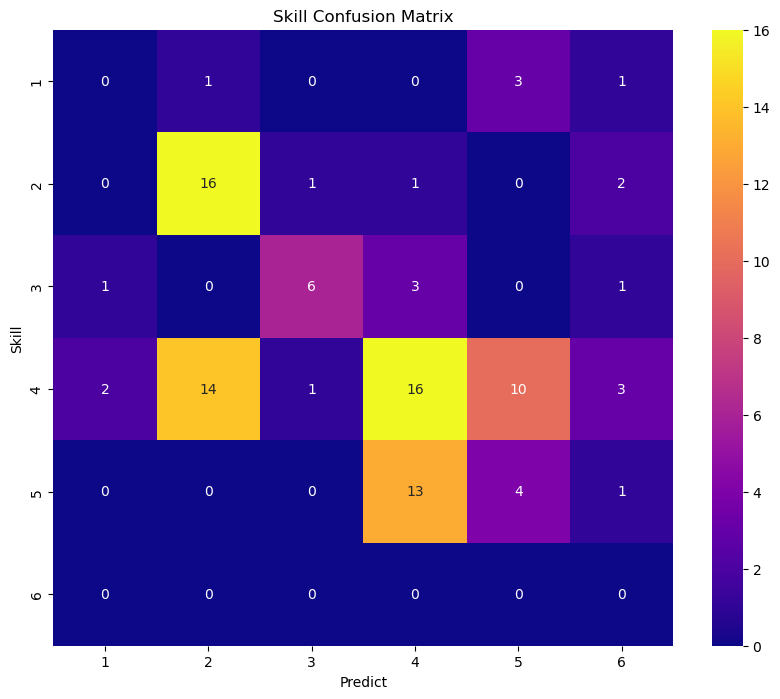

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.52      0.80      0.63        20
           3       0.75      0.55      0.63        11
           4       0.48      0.35      0.41        46
           5       0.24      0.22      0.23        18
           6       0.00      0.00      0.00         0

    accuracy                           0.42       100
   macro avg       0.33      0.32      0.32       100
weighted avg       0.45      0.42      0.42       100



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [370]:
plot_heatmap(skill_list, skill_preds_test2, 'Skill')

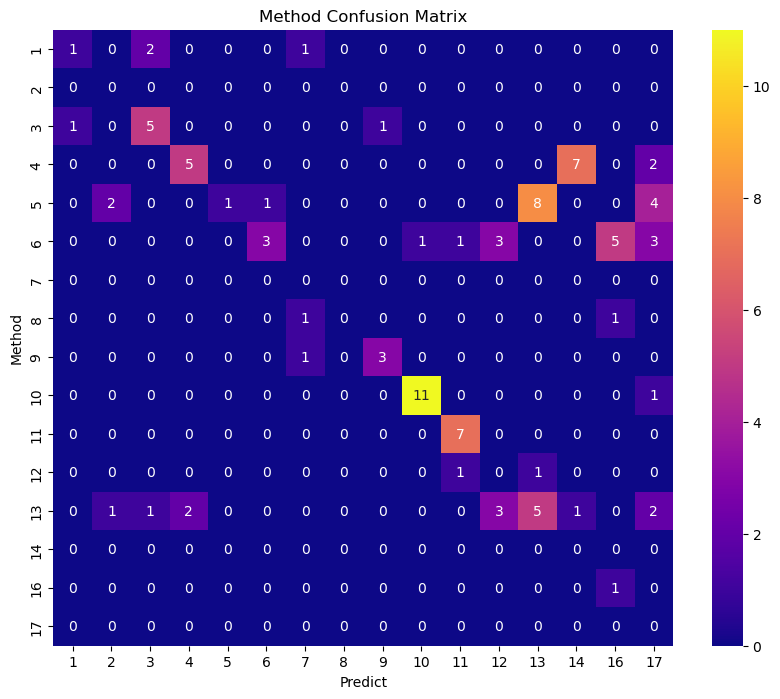

              precision    recall  f1-score   support

           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         0
           3       0.62      0.71      0.67         7
           4       0.71      0.36      0.48        14
           5       1.00      0.06      0.12        16
           6       0.75      0.19      0.30        16
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       0.75      0.75      0.75         4
          10       0.92      0.92      0.92        12
          11       0.78      1.00      0.88         7
          12       0.00      0.00      0.00         2
          13       0.36      0.33      0.34        15
          14       0.00      0.00      0.00         0
          16       0.14      1.00      0.25         1
          17       0.00      0.00      0.00         0

    accuracy                           0.42       100
   macro avg       0.41   

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppDat

In [371]:
plot_heatmap(method_list, method_preds_test2, 'Method')

#### Test3 : base + additional data + role prompt + cot
약간의 성능 향상이 있다고 알려진 role prompting과 cot를 위해 약간의 instruction 수정, 그리고 추론 할 수 있게 하기 위해 추가적인 데이터(본문, 조건, 선지, 정답)를 추가하였다.

In [ ]:
res_list_test3 = []
n_tokens = 0
for question, passage, condition, options, answer in zip(question_list, passage_list, condition_list, options_list, answer_list):
    messages = [{'role' : 'system' , 'content': f'너는 유명한 영어 학원 강사라고 상상해봐. Skill은 이해해야 하는 학습내용을 담은 내용정보를 의미하고, Method는 Skill을 습득하는 방법을 담은 형식정보야.\
너의 업무는 주어진 모든 영어 문제들을 파악하여 각 문제별로 skill과 method를 잘 분류 할 수 있는거야. \
주어진 skill과 method 후보는 skill: {skill}, method: {method}이야. 문제를 읽고 주어지는 질문의 의도를 잘 파악해서 각 list에서 한가지씩 선택하여 답하면 돼'}] # gpt에게 역할을 설정할 수 있다.
    if condition is np.nan:
        if options is np.nan:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 질문: {question}, 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
        else:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 질문: {question}, 선지: {options} 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
    else:
        if options is np.nan:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 조건: {condition}, 질문: {question}, 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
        else:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 조건: {condition}, 질문: {question}, 선지: {options} 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
    
    messages.append({'role':'user', 'content': p})
    if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
        res = openai.ChatCompletion.create(model = model16k_name, messages = messages)
    else:
        res = openai.ChatCompletion.create(model = model_name, messages = messages)
    res_list_test3.append(res['choices'][0]['message']['content'])
    n_tokens += res['usage']['total_tokens']
print(f'usage : {n_tokens/1000 * price:.02f}$')
res_list_test3[:2]

usage : 0.13$


['[skill: content, method: find the irrelevant]',
 'skill: content, method: write a sentence']

In [ ]:
res_list_test3

['[skill: content, method: find the irrelevant]',
 'skill: content, method: write a sentence',
 'skill: "vocabulary"\nmethod: "write a sentence"\n\n해석: 이 문제에서 이해해야 하는 학습내용인 skill은 \'vocabulary\'이다. 문장 내에서 주어진 보기를 사용하여 문장을 작성하는 방식으로 이 skill을 습득할 수 있다.',
 'skill: content\nmethod: find the main idea\n\n이 문제에서 이해해야 하는 학습내용은 본문의 흐름이다. 주어진 문장들을 읽고 본문의 주요 아이디어를 파악해야 한다. 따라서, skill은 content이고 method는 find the main idea이다. ',
 "이 문제에서 이해해야 하는 학습내용인 skill은 'vocabulary'야. 문제에서는 괄호 안에 들어갈 맞는 동일어를 찾는 것이 요구되고 있으므로 vocabulary를 이해하고 있어야 해.\n\n그리고 이 skill을 습득하는 방법으로는 'write or find the right word'가 가장 적합해. 주어진 문맥에서 어떤 단어가 들어가야 하는지 그리고 그 단어는 어떤 의미를 가지고 있는지 파악하고, 주어진 선지들 중에서 가장 적절한 단어를 선택해야 해. 그래서 method는 'write or find the right word'야.",
 '[skill: content, method: find the incorrect]',
 '이 문제에서 이해해야 하는 학습내용인 skill은 "content"이다. 이 문제는 본문의 내용을 이해하고 그에 대한 질문에 올바른 답을 찾는 것이 중요하다.\n\n이러한 skill을 습득하는 방법은 "find the correct / find the incorrect"이다. 문제에서는 올바른 답을 골라야하므로, 주어진 선지 중에서 본문의 내용과 일치하는 올바른 답을 선택해야 한다.',


정답 출력 양식  
1. skill / method 뒤에 skill_name / method_name으로 답변 ex) 'skill: content, method: write a sentence'
2. 1번 뒤에 문제와 연관지어 논리적으로 skill과 method를 선택한 설명을 추가해줌.
3. 1번 뒤에 2번과 유사하지만 다르게 skill과 method를 설명하는게 아니라 문제만 푸는경우도 존재(?)

 '[skill: content, method: find the main idea]\n주어진 본문을 읽어보면 연구자들은 나무꾼의 탄성있는 뼈와 유연한 부리의 기능을 모방하여 기계 장치를 만들기로 결정했다는 내용을 알 수 있습니다. 그들의 목표는 비행기에 장착된 블랙박스를 개선하는 것이었습니다. 이 블랙박스는 비행기 사고의 원인을 파악하기 위해 사용되는데, 하늘에서 떨어지는 충격에 견딜 수 있어야 합니다. 연구자들은 블랙박스의 기록장치를 작은 유리 조각들로 가득 찬 알루미늄 용기 안에 넣었다는데, 이것은 나무꾼의 두개골의 스펀지 뼈의 효과를 재현하기 위한 것이었습니다. 그들은 또한 용기를 고무층으로 덮고, 그 위에 강철층을 덮었습니다. 이 프로젝트는 큰 성공이었고, 새로운 블랙박스는 기존 형태보다 60배나 더 안전했습니다.\n\n따라서, 이 문제의 주제는 "Improvement of black box using flexible nature of woodpecker"이며, 이는 주어진 본문의 주요 아이디어를 찾는 방법에 해당합니다.'  
4. 이상한 method를 선택하는 할루시네이션이 존재 ex) [skill: context, method: find the right sentence placement] > 아마도 position the sentence가 변형된것 같긴함  
=> 대부분에 경우에 skill_name / method_name이 존재

정답 채점 방식(1번과 같음)
1. 소문자로 변환
2. 정규표현식을 사용하여 해당 skill_name과 method_name이 존재하는지 파악
2. 추가설명을 위해 같은 name을 여러번 언급할 수 있으므로 np.unique사용 하여 각 skill, method 별로 한번씩 언급하는지 파악
3. 그 외의 경우: skill 은 6번 method는 17번(range 밖)  

In [ ]:
def pred_parse(string , pats = ['vocabulary', 'grammar', 'expression', 'content', 'context']):
    txt_preds = []
    for idx, pat in enumerate(pats):
        for match in re.finditer(pat, string):
            txt_preds.append(match.group())
    txt_preds = np.unique(txt_preds) # 중복 처리
    if len(txt_preds) == 1:         # 1개 찾은경우
        num_pred = pats.index(txt_preds[0])
    else:                           # 예외 skill label: 5
        num_pred = len(pats)
    return txt_preds, num_pred
text =  "skill: 'content', method: 'arrange the sequence'\n\n- 이 문제에서는 주어진 본문의 내용을 파악하고, 각 문장의 순서를 파악해야 한다. 따라서 문제의 의도는 주어진 문장을 올바른 순서대로 배열하는 것이다.\n- 이해해야 하는 학습내용은 콘텐츠의 순서를 이해하는 것이고, 그 방법은 주어진 문장들을 잘 읽고 파악하여 적절한 순서로 배열하는 것이다.\n- 따라서 skill은 'content'이고, method은 'arrange the sequence'이다."

txt_preds, num_pred = pred_parse(text.lower(), skill)
print(txt_preds, num_pred)
txt_preds, num_pred = pred_parse(text.lower(), method)
print(txt_preds, num_pred)

['content'] 3
['arrange the sequence'] 9


In [ ]:
skill_preds_test3 = []
method_preds_test3 = []
for string in res_list_test3:
    _, s = pred_parse(string.lower(), skill)
    _, m = pred_parse(string.lower(), method)
    skill_preds_test3.append(s+1)
    method_preds_test3.append(m+1)
print(skill_preds_test3[0], method_preds_test3[0])
print(skill_preds_test3[1], method_preds_test3[1])
data = [row for row in zip(res_list_test3, skill_list, method_list, skill_preds_test3, method_preds_test3)]
df_test3 = pd.DataFrame(data, columns=['Response', 'label_skill', 'label_method','pred_skill', 'pred_method'])
df_test3.to_csv("./data/test/test_3.csv")

4 16
4 3


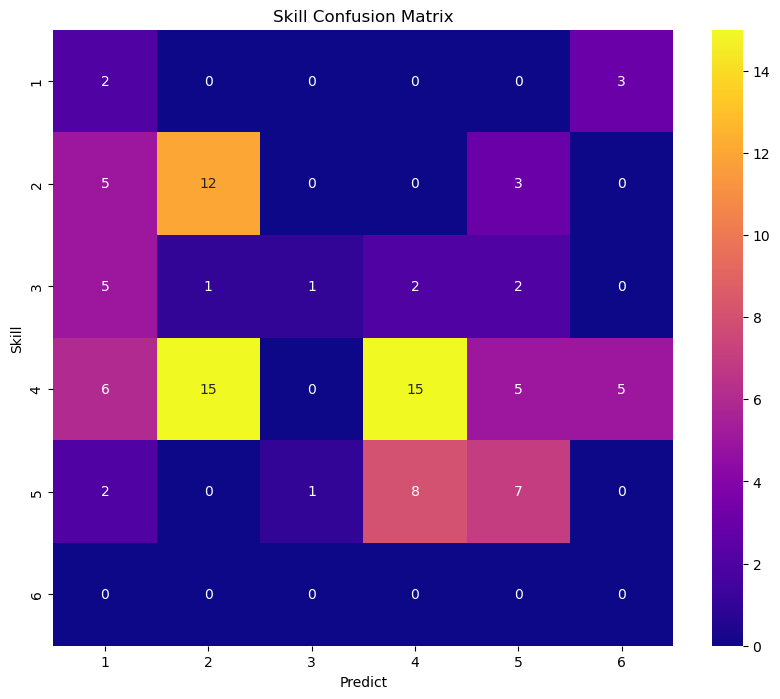

              precision    recall  f1-score   support

           1       0.10      0.40      0.16         5
           2       0.43      0.60      0.50        20
           3       0.50      0.09      0.15        11
           4       0.60      0.33      0.42        46
           5       0.41      0.39      0.40        18
           6       0.00      0.00      0.00         0

    accuracy                           0.37       100
   macro avg       0.34      0.30      0.27       100
weighted avg       0.50      0.37      0.39       100



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_heatmap(skill_list, skill_preds_test3, 'Skill')

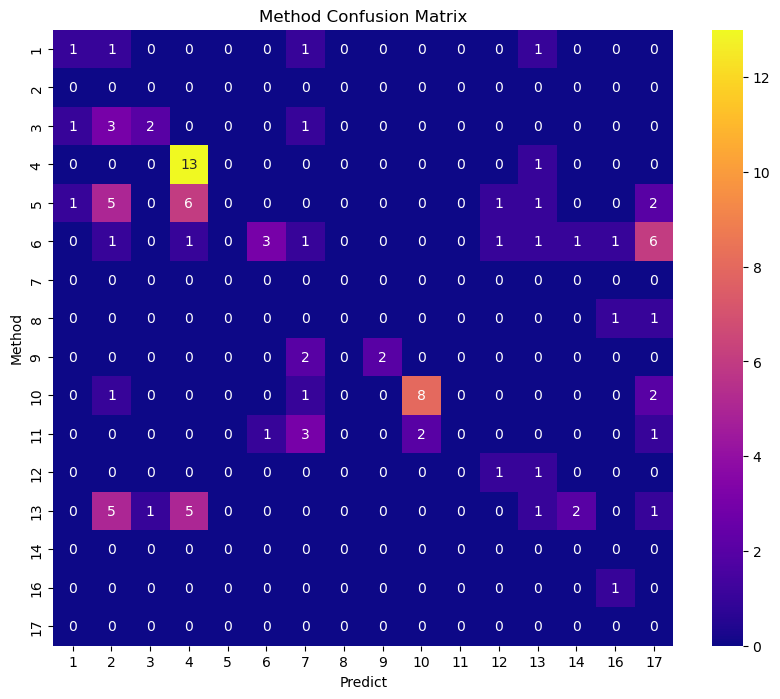

              precision    recall  f1-score   support

           1       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         0
           3       0.67      0.29      0.40         7
           4       0.52      0.93      0.67        14
           5       0.00      0.00      0.00        16
           6       0.75      0.19      0.30        16
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       1.00      0.50      0.67         4
          10       0.80      0.67      0.73        12
          11       0.00      0.00      0.00         7
          12       0.33      0.50      0.40         2
          13       0.17      0.07      0.10        15
          14       0.00      0.00      0.00         0
          16       0.33      1.00      0.50         1
          17       0.00      0.00      0.00         0

    accuracy                           0.32       100
   macro avg       0.31   

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppDat

In [ ]:
plot_heatmap(method_list, method_preds_test3, 'Method')

#### Test3-2 : base + additional data + role prompt + cot + few-shot
논문에서 저자는 4 or 8 shot을 넣어서 추론하기에 sample 되지 않은 데이터 셋에서 query를 뽑아 step by step instruction을 넣어서 prompt를 작성해봄

In [377]:
# test중인 df를 제외한 새로운 데이터프레임 생성
# 여기서 cot를 하기 위해 few-shot 예제를 넣어줌
random_sample_values = random_sample['질문'].tolist()  # random_sample에 있는 값 추출
filtered_df = new_df[~new_df['질문'].isin(random_sample_values)]
new_sample = filtered_df.sample(n=8, random_state=42)
new_sample.

,본문,조건,선지,정답,질문,문제유형,skill,method
10288,We must be careful when looking at proverbs as...,"(A) Nevertheless, the frequent use of certain ...",➀ (A) - (C) - (B) \n➁ (B) - (A) - (C)\n➂ (B) -...,②,다음 글에 이어질 알맞은 글의 순서는?,11.0,4,10
8418,To the male runners it was a one-off event. Wi...,NaN,① 1972년에 보스톤 마라톤에 처음 참가했다.\n② 1984년 올림픽경기의 혼성 ...,③,다음 글을 읽고 Switzer에 관한 내용으로 일치하는 것을 고르시오.,12.0,5,6
2528,Another thing we had to see while in Venice wa...,[보기] \nⓐ an activity involving skill in making...,NaN,ⓐ : craft\nⓑ : souvenir\nⓒ : identity,다음 글의 빈 칸 ⓐ-ⓒ에 들어갈 알맞은 말을 [보기]의 영영풀이를 참고하여 한 단...,34.0,4,13
9332,"When Mary was growing up, (여자 아이들이 고등 교육을 받을 거...",NaN,NaN,girls weren’t expected to pursue an advanced e...,다음 글의 밑줄 친 부분을 알맞게 영작하시오.,24.0,3,3
3125,"In spite of this success, the popularity of he...",NaN,(A) (B) (C)\n① faded ‥‥‥ reevaluated ‥‥‥ recog...,①,"A), (B), (C)의 각 네모 안에서 글의 흐름상 맞는 표현으로 가장 적절한 것은?",27.0,1,5
2689,17세기 말 피아노의 발명은 음악가들이 작곡하고 음악을 연주하는 것을 꽤 가능하게 ...,<underline>the piano / compose and play music ...,"→ At the end of the 17th century, <underline>_...",the invention of the piano made it quite possi...,다음 제시된 단어들을 올바르게 나열하여 우리말과 일치하도록 문장을 완성하시오. (필...,17.0,3,3
6964,People can also get the wrong idea from statis...,NaN,① ⓐ\n② ⓑ\n③ ⓒ\n④ ⓓ\n⑤ ⓔ,⑤,다음 글의 밑줄 친 ⓐ ~ⓔ중 문맥상 낱말의 쓰임이 적절하지 않은 것은?,38.0,4,13
117,A poor position for sleeping is on your side w...,NaN,(A) (B) (C) \n① try not to curved stretch\n② t...,①,"다음 글의 괄호 (A), (B), (C) 안에서 문맥상 들어갈 말로 알맞게 짝지어진...",26.0,2,5


In [395]:
res_list_test3 = []
n_tokens = 0
for question, passage, condition, options, answer in zip(question_list, passage_list, condition_list, options_list, answer_list):
    messages = [{'role' : 'system' , 'content': f'너는 유명한 영어 학원 강사라고 상상해봐. Skill은 이해해야 하는 학습내용을 담은 내용정보를 의미하고, Method는 Skill을 습득하는 방법을 담은 형식정보야.\
너의 업무는 주어진 모든 영어 문제들을 파악하여 각 문제별로 skill과 method를 잘 분류 할 수 있는거야. \
주어진 skill과 method 후보는 skill: {skill}, method: {method}이야. 문제를 읽고 주어지는 질문의 의도를 잘 파악해서 각 list에서 한가지씩 선택하여 답하면 돼'}] # gpt에게 역할을 설정할 수 있다.
    if condition is np.nan:
        if options is np.nan:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 질문: {question}, 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
        else:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 질문: {question}, 선지: {options} 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
    else:
        if options is np.nan:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 조건: {condition}, 질문: {question}, 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
        else:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 조건: {condition}, 질문: {question}, 선지: {options} 정답: {answer}. 이 문제에서 이해해야 하는 학습내용인 skill과 그 Skill을 습득하는 방법을 담은 형식정보인 method는 각각 무엇인지 단계별로 이유를 들어서 [skill: skill_name, method: method_name] 형식으로 꼭 한가지만 골라서 답해줘."
    
    messages.append({'role':'user', 'content': p})
    if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
        res = openai.ChatCompletion.create(model = model16k_name, messages = messages)
    else:
        res = openai.ChatCompletion.create(model = model_name, messages = messages)
    res_list_test3.append(res['choices'][0]['message']['content'])
    n_tokens += res['usage']['total_tokens']
print(f'usage : {n_tokens/1000 * price:.02f}$')
res_list_test3[:2]

usage : 0.13$


['[skill: content, method: find the irrelevant]',
 'skill: content, method: write a sentence']

In [396]:
res_list_test3

['[skill: content, method: find the irrelevant]',
 'skill: content, method: write a sentence',
 'skill: "vocabulary"\nmethod: "write a sentence"\n\n해석: 이 문제에서 이해해야 하는 학습내용인 skill은 \'vocabulary\'이다. 문장 내에서 주어진 보기를 사용하여 문장을 작성하는 방식으로 이 skill을 습득할 수 있다.',
 'skill: content\nmethod: find the main idea\n\n이 문제에서 이해해야 하는 학습내용은 본문의 흐름이다. 주어진 문장들을 읽고 본문의 주요 아이디어를 파악해야 한다. 따라서, skill은 content이고 method는 find the main idea이다. ',
 "이 문제에서 이해해야 하는 학습내용인 skill은 'vocabulary'야. 문제에서는 괄호 안에 들어갈 맞는 동일어를 찾는 것이 요구되고 있으므로 vocabulary를 이해하고 있어야 해.\n\n그리고 이 skill을 습득하는 방법으로는 'write or find the right word'가 가장 적합해. 주어진 문맥에서 어떤 단어가 들어가야 하는지 그리고 그 단어는 어떤 의미를 가지고 있는지 파악하고, 주어진 선지들 중에서 가장 적절한 단어를 선택해야 해. 그래서 method는 'write or find the right word'야.",
 '[skill: content, method: find the incorrect]',
 '이 문제에서 이해해야 하는 학습내용인 skill은 "content"이다. 이 문제는 본문의 내용을 이해하고 그에 대한 질문에 올바른 답을 찾는 것이 중요하다.\n\n이러한 skill을 습득하는 방법은 "find the correct / find the incorrect"이다. 문제에서는 올바른 답을 골라야하므로, 주어진 선지 중에서 본문의 내용과 일치하는 올바른 답을 선택해야 한다.',


정답 출력 양식  
1. skill / method 뒤에 skill_name / method_name으로 답변 ex) 'skill: content, method: write a sentence'
2. 1번 뒤에 문제와 연관지어 논리적으로 skill과 method를 선택한 설명을 추가해줌.
3. 1번 뒤에 2번과 유사하지만 다르게 skill과 method를 설명하는게 아니라 문제만 푸는경우도 존재(?)

 '[skill: content, method: find the main idea]\n주어진 본문을 읽어보면 연구자들은 나무꾼의 탄성있는 뼈와 유연한 부리의 기능을 모방하여 기계 장치를 만들기로 결정했다는 내용을 알 수 있습니다. 그들의 목표는 비행기에 장착된 블랙박스를 개선하는 것이었습니다. 이 블랙박스는 비행기 사고의 원인을 파악하기 위해 사용되는데, 하늘에서 떨어지는 충격에 견딜 수 있어야 합니다. 연구자들은 블랙박스의 기록장치를 작은 유리 조각들로 가득 찬 알루미늄 용기 안에 넣었다는데, 이것은 나무꾼의 두개골의 스펀지 뼈의 효과를 재현하기 위한 것이었습니다. 그들은 또한 용기를 고무층으로 덮고, 그 위에 강철층을 덮었습니다. 이 프로젝트는 큰 성공이었고, 새로운 블랙박스는 기존 형태보다 60배나 더 안전했습니다.\n\n따라서, 이 문제의 주제는 "Improvement of black box using flexible nature of woodpecker"이며, 이는 주어진 본문의 주요 아이디어를 찾는 방법에 해당합니다.'  
4. 이상한 method를 선택하는 할루시네이션이 존재 ex) [skill: context, method: find the right sentence placement] > 아마도 position the sentence가 변형된것 같긴함  
=> 대부분에 경우에 skill_name / method_name이 존재

정답 채점 방식(1번과 같음)
1. 소문자로 변환
2. 정규표현식을 사용하여 해당 skill_name과 method_name이 존재하는지 파악
2. 추가설명을 위해 같은 name을 여러번 언급할 수 있으므로 np.unique사용 하여 각 skill, method 별로 한번씩 언급하는지 파악
3. 그 외의 경우: skill 은 6번 method는 17번(range 밖)  

In [398]:
def pred_parse(string , pats = ['vocabulary', 'grammar', 'expression', 'content', 'context']):
    txt_preds = []
    for idx, pat in enumerate(pats):
        for match in re.finditer(pat, string):
            txt_preds.append(match.group())
    txt_preds = np.unique(txt_preds) # 중복 처리
    if len(txt_preds) == 1:         # 1개 찾은경우
        num_pred = pats.index(txt_preds[0])
    else:                           # 예외 skill label: 5
        num_pred = len(pats)
    return txt_preds, num_pred
text =  "skill: 'content', method: 'arrange the sequence'\n\n- 이 문제에서는 주어진 본문의 내용을 파악하고, 각 문장의 순서를 파악해야 한다. 따라서 문제의 의도는 주어진 문장을 올바른 순서대로 배열하는 것이다.\n- 이해해야 하는 학습내용은 콘텐츠의 순서를 이해하는 것이고, 그 방법은 주어진 문장들을 잘 읽고 파악하여 적절한 순서로 배열하는 것이다.\n- 따라서 skill은 'content'이고, method은 'arrange the sequence'이다."

txt_preds, num_pred = pred_parse(text.lower(), skill)
print(txt_preds, num_pred)
txt_preds, num_pred = pred_parse(text.lower(), method)
print(txt_preds, num_pred)

['content'] 3
['arrange the sequence'] 9


In [399]:
skill_preds_test3 = []
method_preds_test3 = []
for string in res_list_test3:
    _, s = pred_parse(string.lower(), skill)
    _, m = pred_parse(string.lower(), method)
    skill_preds_test3.append(s+1)
    method_preds_test3.append(m+1)
print(skill_preds_test3[0], method_preds_test3[0])
print(skill_preds_test3[1], method_preds_test3[1])
data = [row for row in zip(res_list_test3, skill_list, method_list, skill_preds_test3, method_preds_test3)]
df_test3 = pd.DataFrame(data, columns=['Response', 'label_skill', 'label_method','pred_skill', 'pred_method'])
df_test3.to_csv("./data/test/test_3.csv")

4 16
4 3


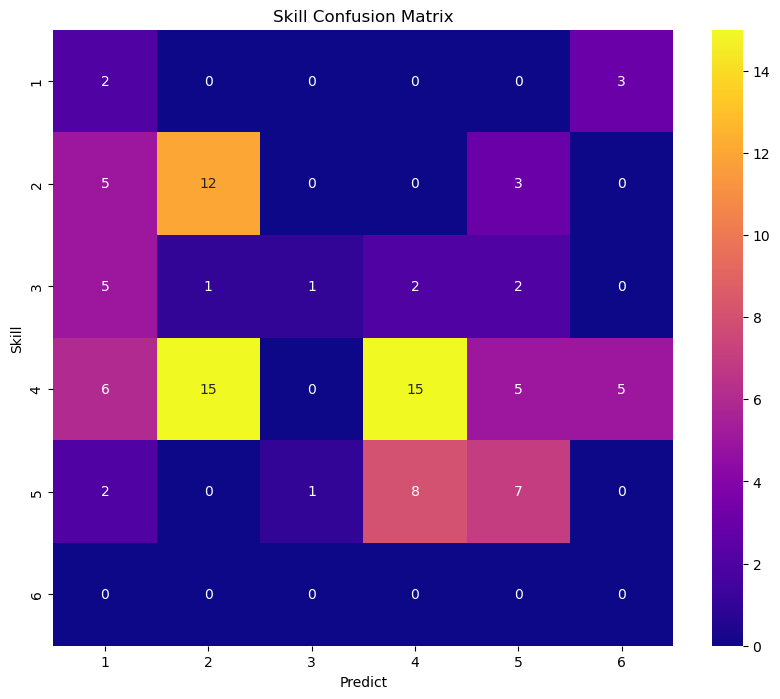

              precision    recall  f1-score   support

           1       0.10      0.40      0.16         5
           2       0.43      0.60      0.50        20
           3       0.50      0.09      0.15        11
           4       0.60      0.33      0.42        46
           5       0.41      0.39      0.40        18
           6       0.00      0.00      0.00         0

    accuracy                           0.37       100
   macro avg       0.34      0.30      0.27       100
weighted avg       0.50      0.37      0.39       100



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [400]:
plot_heatmap(skill_list, skill_preds_test3, 'Skill')

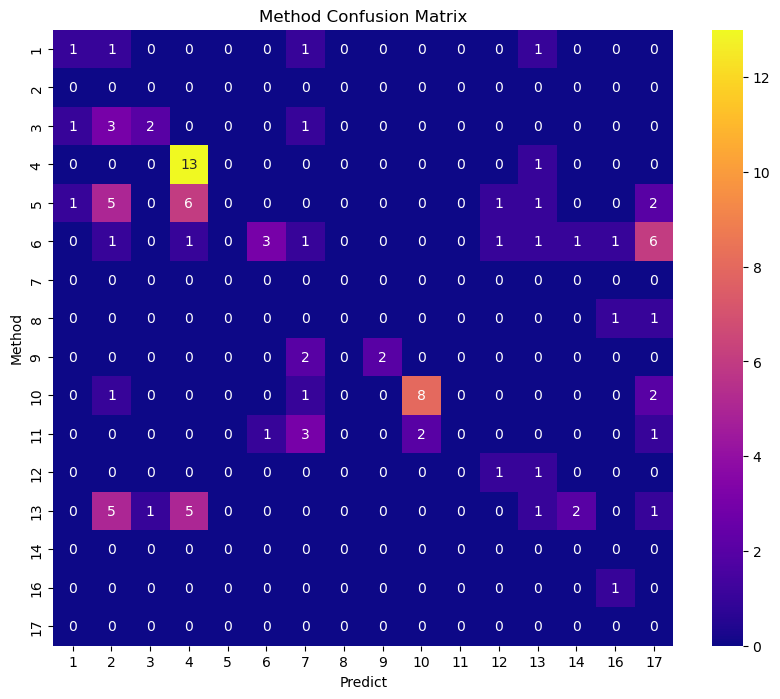

              precision    recall  f1-score   support

           1       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         0
           3       0.67      0.29      0.40         7
           4       0.52      0.93      0.67        14
           5       0.00      0.00      0.00        16
           6       0.75      0.19      0.30        16
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       1.00      0.50      0.67         4
          10       0.80      0.67      0.73        12
          11       0.00      0.00      0.00         7
          12       0.33      0.50      0.40         2
          13       0.17      0.07      0.10        15
          14       0.00      0.00      0.00         0
          16       0.33      1.00      0.50         1
          17       0.00      0.00      0.00         0

    accuracy                           0.32       100
   macro avg       0.31   

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppDat

In [401]:
plot_heatmap(method_list, method_preds_test3, 'Method')

#### Test4 : Test3 - cot + split subtasks
위에서 논의하였던 방식으로 질문을 나누어서 질의한다. test3에서 cot를 제외하고 질의 할 예정이다.

(+ 문제, 보기, 선지를 제시)를 참조하여 아래의 순서에 따라 질문을 답하여라
1. 주어진 문제를 풀고 이유를 들어 정답을 말해라.
2. 1번 문제를 풀기 위해 필요한 comprehension ability(이해능력)이 무엇인가?
3. 2번의 comprehension ability(이해능력)을 참고하여 1번 문제를 풀기 위해 사용된 method(방법)이 무엇인가?
4. 2,3번의 comprehension ability와 method를 참고하여 제시된 문제유형을 맞춰라.

In [407]:
res_list_test4 = []
n_tokens = 0
for question, passage, condition, optionsin in zip(question_list, passage_list, condition_list, options_list):
    messages = [{'role' : 'system', 'content': f'너는 유명한 영어 학원 강사라고 상상해봐. Comprehension ability은 이해해야 하는 학습내용을 담은 내용정보를 의미하고, Method는 Comprehension ability을 습득하는 방법을 담은 형식정보야.\
너의 업무는 주어진 모든 영어 문제들을 파악하여 각 문제별로 Comprehension ability과 method를 잘 분류 하여 최종적으로 문제 유형을 알아 내는거야 \
주어진 Comprehension ability과 method 그리고 문제유형 후보는 Comprehension ability: {skill}, method: {method}, 문제유형: {problem_type_list}야. 문제를 읽고 주어지는 질문의 의도를 잘 파악해서 각 list에서 한가지씩만 선택하여 답하면 돼'}] # gpt에게 역할을 설정할 수 있다.
    if condition is np.nan:
        if options is np.nan:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 질문: {question}."
        else:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 질문: {question}, 선지: {options}."
    else:
        if options is np.nan:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 조건: {condition}, 질문: {question}."
        else:
            p = f"먼저 영어 문제를 봐줘. 본문: {passage}, 조건: {condition}, 질문: {question}, 선지: {options}."
    
    p += "이 문제를 참고하여 아래의 순서에 따라 질문을 답해줘. 1. 제시된 문제를 풀고 근거를 들어 정답을 말해줘. 2. 1번 문제를 풀기 위한 Comprehension ability이 무엇이야? 가장 적절한 한가지만 골라서 답해줘. 3. 2번의 Comprehension ability을 참고하여 문제를 풀기 위해 사용된 Method가 무엇인지 가장 적절한 한가지만 선택해서 답해줘. 4. 2번,3번의 Comprehension ability와 method를 참고하여 문제유형중 가장 적절한 한가지만 선택해서 답해줘"
    messages.append({'role':'user', 'content': p})
    if num_tokens_from_messages(messages) > 4000: # 토큰수가 넘어가면 16k모델로 돌림
        res = openai.ChatCompletion.create(model = model16k_name, messages = messages)
    else:
        res = openai.ChatCompletion.create(model = model_name, messages = messages)
    res_list_test4.append(res['choices'][0]['message']['content'])
    n_tokens += res['usage']['total_tokens']
print(f'usage : {n_tokens/1000 * price:.02f}$')
res_list_test4[:2]

In [ ]:
res_list_test4

['[skill: content, method: find the irrelevant]',
 'skill: content, method: write a sentence',
 'skill: "vocabulary"\nmethod: "write a sentence"\n\n해석: 이 문제에서 이해해야 하는 학습내용인 skill은 \'vocabulary\'이다. 문장 내에서 주어진 보기를 사용하여 문장을 작성하는 방식으로 이 skill을 습득할 수 있다.',
 'skill: content\nmethod: find the main idea\n\n이 문제에서 이해해야 하는 학습내용은 본문의 흐름이다. 주어진 문장들을 읽고 본문의 주요 아이디어를 파악해야 한다. 따라서, skill은 content이고 method는 find the main idea이다. ',
 "이 문제에서 이해해야 하는 학습내용인 skill은 'vocabulary'야. 문제에서는 괄호 안에 들어갈 맞는 동일어를 찾는 것이 요구되고 있으므로 vocabulary를 이해하고 있어야 해.\n\n그리고 이 skill을 습득하는 방법으로는 'write or find the right word'가 가장 적합해. 주어진 문맥에서 어떤 단어가 들어가야 하는지 그리고 그 단어는 어떤 의미를 가지고 있는지 파악하고, 주어진 선지들 중에서 가장 적절한 단어를 선택해야 해. 그래서 method는 'write or find the right word'야.",
 '[skill: content, method: find the incorrect]',
 '이 문제에서 이해해야 하는 학습내용인 skill은 "content"이다. 이 문제는 본문의 내용을 이해하고 그에 대한 질문에 올바른 답을 찾는 것이 중요하다.\n\n이러한 skill을 습득하는 방법은 "find the correct / find the incorrect"이다. 문제에서는 올바른 답을 골라야하므로, 주어진 선지 중에서 본문의 내용과 일치하는 올바른 답을 선택해야 한다.',


정답 출력 양식  
1. skill / method 뒤에 skill_name / method_name으로 답변 ex) 'skill: content, method: write a sentence'
2. 1번 뒤에 문제와 연관지어 논리적으로 skill과 method를 선택한 설명을 추가해줌.
3. 1번 뒤에 2번과 유사하지만 다르게 skill과 method를 설명하는게 아니라 문제만 푸는경우도 존재(?)

 '[skill: content, method: find the main idea]\n주어진 본문을 읽어보면 연구자들은 나무꾼의 탄성있는 뼈와 유연한 부리의 기능을 모방하여 기계 장치를 만들기로 결정했다는 내용을 알 수 있습니다. 그들의 목표는 비행기에 장착된 블랙박스를 개선하는 것이었습니다. 이 블랙박스는 비행기 사고의 원인을 파악하기 위해 사용되는데, 하늘에서 떨어지는 충격에 견딜 수 있어야 합니다. 연구자들은 블랙박스의 기록장치를 작은 유리 조각들로 가득 찬 알루미늄 용기 안에 넣었다는데, 이것은 나무꾼의 두개골의 스펀지 뼈의 효과를 재현하기 위한 것이었습니다. 그들은 또한 용기를 고무층으로 덮고, 그 위에 강철층을 덮었습니다. 이 프로젝트는 큰 성공이었고, 새로운 블랙박스는 기존 형태보다 60배나 더 안전했습니다.\n\n따라서, 이 문제의 주제는 "Improvement of black box using flexible nature of woodpecker"이며, 이는 주어진 본문의 주요 아이디어를 찾는 방법에 해당합니다.'  
4. 이상한 method를 선택하는 할루시네이션이 존재 ex) [skill: context, method: find the right sentence placement] > 아마도 position the sentence가 변형된것 같긴함  
=> 대부분에 경우에 skill_name / method_name이 존재

정답 채점 방식(1번과 같음)
1. 소문자로 변환
2. 정규표현식을 사용하여 해당 skill_name과 method_name이 존재하는지 파악
2. 추가설명을 위해 같은 name을 여러번 언급할 수 있으므로 np.unique사용 하여 각 skill, method 별로 한번씩 언급하는지 파악
3. 그 외의 경우: skill 은 6번 method는 17번(range 밖)  

In [ ]:
def pred_parse(string , pats = ['vocabulary', 'grammar', 'expression', 'content', 'context']):
    txt_preds = []
    for idx, pat in enumerate(pats):
        for match in re.finditer(pat, string):
            txt_preds.append(match.group())
    txt_preds = np.unique(txt_preds) # 중복 처리
    if len(txt_preds) == 1:         # 1개 찾은경우
        num_pred = pats.index(txt_preds[0])
    else:                           # 예외 skill label: 5
        num_pred = len(pats)
    return txt_preds, num_pred
text =  "skill: 'content', method: 'arrange the sequence'\n\n- 이 문제에서는 주어진 본문의 내용을 파악하고, 각 문장의 순서를 파악해야 한다. 따라서 문제의 의도는 주어진 문장을 올바른 순서대로 배열하는 것이다.\n- 이해해야 하는 학습내용은 콘텐츠의 순서를 이해하는 것이고, 그 방법은 주어진 문장들을 잘 읽고 파악하여 적절한 순서로 배열하는 것이다.\n- 따라서 skill은 'content'이고, method은 'arrange the sequence'이다."

txt_preds, num_pred = pred_parse(text.lower(), skill)
print(txt_preds, num_pred)
txt_preds, num_pred = pred_parse(text.lower(), method)
print(txt_preds, num_pred)

['content'] 3
['arrange the sequence'] 9


In [ ]:
skill_preds_test4 = []
method_preds_test4 = []
for string in res_list_test4:
    _, s = pred_parse(string.lower(), skill)
    _, m = pred_parse(string.lower(), method)
    skill_preds_test4.append(s+1)
    method_preds_test4.append(m+1)
print(skill_preds_test4[0], method_preds_test4[0])
print(skill_preds_test4[1], method_preds_test4[1])
data = [row for row in zip(res_list_test4, skill_list, method_list, skill_preds_test4, method_preds_test4)]
df_test4 = pd.DataFrame(data, columns=['Response', 'label_skill', 'label_method','pred_skill', 'pred_method'])
df_test4.to_csv("./data/test/test_4.csv")

4 16
4 3


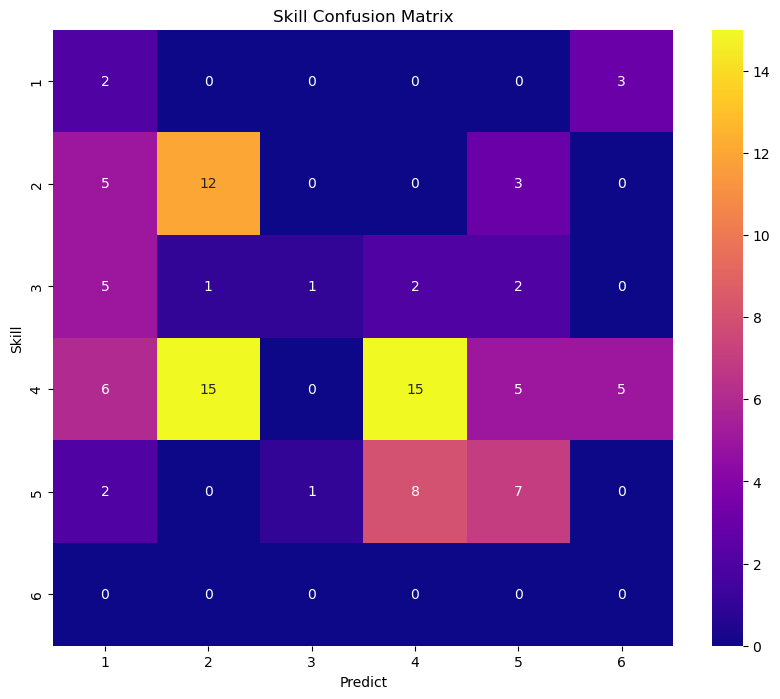

              precision    recall  f1-score   support

           1       0.10      0.40      0.16         5
           2       0.43      0.60      0.50        20
           3       0.50      0.09      0.15        11
           4       0.60      0.33      0.42        46
           5       0.41      0.39      0.40        18
           6       0.00      0.00      0.00         0

    accuracy                           0.37       100
   macro avg       0.34      0.30      0.27       100
weighted avg       0.50      0.37      0.39       100



c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_heatmap(skill_list, skill_preds_test4, 'Skill')

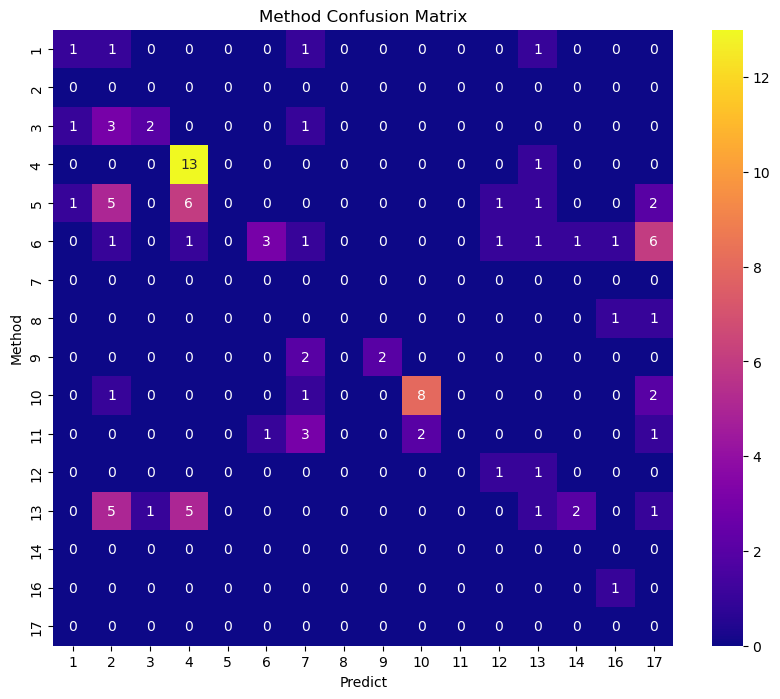

              precision    recall  f1-score   support

           1       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         0
           3       0.67      0.29      0.40         7
           4       0.52      0.93      0.67        14
           5       0.00      0.00      0.00        16
           6       0.75      0.19      0.30        16
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       1.00      0.50      0.67         4
          10       0.80      0.67      0.73        12
          11       0.00      0.00      0.00         7
          12       0.33      0.50      0.40         2
          13       0.17      0.07      0.10        15
          14       0.00      0.00      0.00         0
          16       0.33      1.00      0.50         1
          17       0.00      0.00      0.00         0

    accuracy                           0.32       100
   macro avg       0.31   

c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\grace\AppDat

In [ ]:
plot_heatmap(method_list, method_preds_test4, 'Method')

#### Test5 : Test3 - cot + split subtasks + label description
4번 test에서 약간 변형이 된것이다.

(+ 문제, 보기, 선지를 제시)를 참조하여 아래의 순서에 따라 질문을 답하여라. 단, 누락한 순서가 있다면 추가적으로 단계를 추가해서 답해도 된다.
1. 주어진 문제를 풀고 이유를 들어 정답을 말해라.
2. 주어진 comprehension ability list 와 method list에 대해서 각 list 원소별로 어떤 능력 혹은 방법인지 설명해라. 
3. 1번 문제를 풀기 위해 필요한 comprehension ability(이해능력)이 무엇인가?
4. 3번의 comprehension ability(이해능력)을 참고하여 1번 문제를 풀기 위해 사용된 method(방법)이 무엇인가?
5. 3,4번의 comprehension ability와 method를 참고하여 제시된 문제유형을 맞춰라.